**Table of contents**<a id='toc0_'></a>    
- [HuaweiCup Competition 2021 D Question](#toc1_)    
- [我们采取填充这种形式的考虑依据如下：](#toc2_)    
- [问题1，对所有特征进行排序，使用XGBOOST](#toc3_)    
- [强相关变量对](#toc4_)    
- [有9个变量强相关，所以需要去掉强相关的变量。目前使用2个强相关特征，保留权重高的特征。](#toc5_)    
- [问题2](#toc6_)    
- [多种模型预测](#toc7_)    
- [refer information](#toc8_)    
- [问题3 分类预测](#toc9_)    
- [XGBOOST进行预测](#toc10_)    
- [对caco](#toc11_)    
- [CYP3A4](#toc12_)    
- [对chERG](#toc13_)    
- [对HOB](#toc14_)    
- [对MN](#toc15_)    
- [问题4](#toc16_)    
- [注意](#toc17_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[HuaweiCup Competition 2021 D Question](#toc0_)
- 相比于原始代码。对没必要的代码进行了删除。同时为了方便上传，赛后重新完整运行了一次。
- 编译环境如下：

|编号|开发环境名称|版本|
|---|---|---|
|1|windows|1803|
|2|python|3.7.9|
|3|pandas|1.3.0|
|4|numpy|1.19.5|
|5|scikit-learn|0.24.2|
|6|tensorflow|2.5.0|
|7|scikit-opt|0.6.5|
|8|matplotlib|3.4.2|
|9|seaborn|0.11.2|
|10|vscode|1.16.1|
|11|jupyter|1.0.0|
|12|markdown|3.3.4|
|13|xgboost|1.4.2|
|14|math|defualt|
|15|keras-nightly|2.5.0|

In [1]:
# 引用库

# 基础库
import os
import time
from datetime import date, datetime
import datetime

# 数据处理
import re # 正则化处理
import string
from random import randint
import pandas as pd
import numpy as np
from sklearn import preprocessing
import sklearn 
# 数据预处理
from numpy import polyfit, poly1d, polyval
from pandas.core.frame import DataFrame
from math import ceil
import math
from sklearn.decomposition import PCA

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 归一化函数
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# 模型及预测
# CNN模型
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
# 分类模型
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
# import lightgbm as lgb

import xgboost as xgb
from xgboost import plot_importance
# 评价函数
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve
# tf中dataset数据处理所需库
from tensorflow import feature_column
from tensorflow.keras import layers


%matplotlib inline

In [2]:

def DisplayStartInfo():
    """
    :description: 显示开始时间。
    :param None {type: None}: 
    :return startTime {type: datetime.datetime}{count: 1}: 返回当前时间。
    """
    print("-------------------------Start-------------------------")
    startTime = datetime.datetime.now()
    print(startTime.strftime('%Y-%m-%d %H:%M:%S'))
    return startTime


def DisplayCompletedInfo(startTime=datetime.datetime.now(), isDisplayTimeConsumed=False):
    """
    :description: 显示结束时间信息。
    :param startTime {type: datetime.datetime} {default: datetime.datetime.now()}:: 显示开始时间。default值搭配着isDisplayTimeConsumed=False一起使用，这个时候可以不输出消耗时间。
    :param isDisplayTimeConsumed {type: bool} {default: False}: 是否显示消耗的时间，默认值不显示。
    :return None {count: 0}: 
    """
    if isDisplayTimeConsumed==True:
        print('Time consumed:', str(datetime.datetime.now() - startTime).split('.')[0])
    print("Completed at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ".\n")
    print("-------------------------Completed-------------------------")

def DisplaySeparator():
    print("---------------------------------------------------------\n")

In [3]:
# 也是标签数据集，用于分类预测的结构。
admet_origin = pd.read_csv("./data/ADMET.csv")

# 生物活性数据集，也就是labels数据集。用其中的pIC50列数据作为标签函数。
ERa_activity_origin = pd.read_csv("./data/ERa_activity.csv")

# 样本数据集。里面有物理、化学和拓扑结构特征样本。
Molecular_Descriptor_origin = pd.read_csv("./data/Molecular_Descriptor.csv")

Molecular_Descriptor_test_origin = pd.read_csv("./data/Molecular_Descriptor_test.csv")

print(admet_origin.shape)
print(ERa_activity_origin.shape)
print(Molecular_Descriptor_origin.shape)
print(Molecular_Descriptor_test_origin.shape)
DisplayCompletedInfo()

(1974, 6)
(1974, 3)
(1974, 730)
(50, 730)
Completed at 2021-10-20 09:56:37.

-------------------------Completed-------------------------


In [4]:
describe_origin = pd.read_csv("./data/describe.csv", encoding='ANSI')
describe_pd = describe_origin.iloc[:729,:].copy()
# print(describe_pd.head(20))
print(describe_pd.shape)
print(describe_pd.iloc[728,:])

(729, 4)
DescriptorJavaClass                                ZagrebIndexDescriptor
Descriptor                                                        Zagreb
Description            Sum of the squares of atom degree over all hea...
Class                                                                 2D
Name: 728, dtype: object


In [5]:
# 将所有为空的DescriptorJavaClass赋值。
tempRowContent = ""
for index, row in describe_pd.iterrows():
    if pd.isna(row['DescriptorJavaClass']) == True:
        row['DescriptorJavaClass'] = tempRowContent
    tempRowContent = row['DescriptorJavaClass']
print(describe_pd.head(20))

             DescriptorJavaClass  Descriptor  \
0     AcidicGroupCountDescriptor       nAcid   
1                ALOGPDescriptor       ALogP   
2                ALOGPDescriptor      ALogP2   
3                ALOGPDescriptor         AMR   
4                 APolDescriptor        apol   
5   AromaticAtomsCountDescriptor  naAromAtom   
6   AromaticBondsCountDescriptor   nAromBond   
7            AtomCountDescriptor       nAtom   
8            AtomCountDescriptor  nHeavyAtom   
9            AtomCountDescriptor          nH   
10           AtomCountDescriptor          nB   
11           AtomCountDescriptor          nC   
12           AtomCountDescriptor          nN   
13           AtomCountDescriptor          nO   
14           AtomCountDescriptor          nS   
15           AtomCountDescriptor          nP   
16           AtomCountDescriptor          nF   
17           AtomCountDescriptor         nCl   
18           AtomCountDescriptor         nBr   
19           AtomCountDescriptor        

In [6]:
Molecular_Descriptor_pd = Molecular_Descriptor_origin.copy()
print(Molecular_Descriptor_pd.shape)
Molecular_Descriptor_pd.drop('SMILES', axis=1, inplace=True)
print(Molecular_Descriptor_pd.shape)


Molecular_Descriptor_test_pd = Molecular_Descriptor_test_origin.copy()
print(Molecular_Descriptor_test_pd.shape)
Molecular_Descriptor_test_pd.drop('SMILES', axis=1, inplace=True)
print(Molecular_Descriptor_test_pd.shape)

(1974, 730)
(1974, 729)
(50, 730)
(50, 729)


In [7]:
mdmin = Molecular_Descriptor_pd.min()
mdmax = Molecular_Descriptor_pd.max()
mdmean = Molecular_Descriptor_pd.mean()

mdtmin = Molecular_Descriptor_test_pd.min()
mdtmax = Molecular_Descriptor_test_pd.max()
mdtmean = Molecular_Descriptor_test_pd.mean()

In [8]:
featureRangePD = pd.DataFrame()
featureRangePD['Molecular_Descriptor_min'] = mdmin
featureRangePD['Molecular_Descriptor_max'] = mdmax
featureRangePD['Molecular_Descriptor_mean'] = mdmean
featureRangePD['Molecular_Descriptor_test_min'] = mdtmin
featureRangePD['Molecular_Descriptor_test_max'] = mdtmax
featureRangePD['Molecular_Descriptor_test_mean'] = mdmean

print(featureRangePD.shape)

(729, 6)


In [9]:
featureRangePD.to_csv("./data/1output_featureRange.csv")

In [10]:
describe_pd.isna().sum()

DescriptorJavaClass    0
Descriptor             0
Description            0
Class                  0
dtype: int64

# <a id='toc2_'></a>[我们采取填充这种形式的考虑依据如下：](#toc0_)
训练集和测试集的数据在全为0的列上有以下几个特征：
1. 训练集和测试集中均存在大量的全为0的列。设：训练集全为0的列的集合为A，测试集中全为0的列集合为B。
2. A中元素个数为225个，B中元素个数为305个。他们之间相差81个元素。
3. $A\bigcap B$的个位数为224个（交集），$B\setminus A$的个数是81个（B对A的差集）。需要强调的是$A\subsetneq B$，且这个元素是n10Ring这一列。
4. 单个特征均存在同类化学含义且不为零的特征。
对上述性质的化学含义为：
1. 单个特征全零以为着对于当前目标该特征影响可能性比较低，但并不意味着该特征和其他特征节后之后对目标没有影响。
2. 存在未知特征是否对目标起作用不确定性比较强。
3. 特征的存在性必须保留。

基于上述原因，对数据集中全为0的列做出同类选择填充处理。填充处理的具体方式如下：
1. 代码实现参数化的填充方式，也就是说可以选择多种填充方式。其中全0填充是不填充的一个特例。
2. 为了减弱填充导致的特征权重增强的情况，使用均值减去最小值的方式来完成填充。从而完成既达到保留特征，有尽可能降低全零特征权重的目的。

In [11]:
# 需要说明class中2D和3D从一般意义上来说对最后的结果影响不大。
class preprocessZeroColumn:
    # FeatureType_PD, Features_PD, 
    def __init__(self, calcType='avg'):
        """[summary]

        Args:
            FeatureType_PD ([pandas.DataFrame]): [description]
            Features_PD ([pandas.DataFrame]]): [输入的特征数据集是不带名称列的。
            在这这个例子里面就是不带SMILES列。这一点非常重要]
        """
        self.describe_pd = pd.DataFrame()
        self.features_pd = pd.DataFrame()
        self.FeatureColumns = []
        self.calcType = calcType
        pass

    def calculateFeatureFitValue(self, SameTypeFeaturesList):
        result = 0.0
        if self.calcType == "diff":
            pass
        else:
            temp = self.features_pd[SameTypeFeaturesList].mean().sum()/len(SameTypeFeaturesList)
            result = math.modf(temp)[0]
        # print(result)
        return result
        

    # 在进行比较的时候需要将特征名称都变为小写。数据中和解释中名称的大小写不一致。
    # 所在在比较的时候都处理为小写了。
    def preprocessZeroColumn(self, FeatureType_PD, Features_PD):
        i = 0
        self.describe_pd = FeatureType_PD.copy()
        self.features_pd = Features_PD.copy()
        self.FeatureColumns = Features_PD.columns
        
        # print(self.FeatureColumns)
        tempSameTypeFeaturesList = []
        # 初始化为第一个类型名称。
        tempTypeName = "AcidicGroupCountDescriptor"
        # 初始化为第一个变量名称。
        tempFeatureName = "nAcid"
        
        columnNameIndex = 0
        # ttt = []

        # 先找出所有同类型的特征。
        for columnName, column in self.features_pd.items():
            if column.mean() == 0:
                columnNameIndex = self.FeatureColumns.to_list().index(columnName)
                # 如果这次循环的类型和上次循环的类型相同，那么前面计算出来的总的填充值还可以再使用。
                # print(columnNameIndex, self.describe_pd.at[columnNameIndex, 'DescriptorJavaClass'])
                if self.describe_pd.at[columnNameIndex, 'DescriptorJavaClass'].lower() == tempTypeName.lower():
                    column = pd.Series([sameTypeFeatureFillValue for n in range(self.features_pd.shape[0])])
                else:
                    # 从头开始按行遍历describe_origin。
                    tempSameTypeFeaturesList = []
                    # 初始化为第一个类型名称。
                    tempTypeName = "AcidicGroupCountDescriptor"
                    # 初始化为第一个变量名称。
                    tempFeatureName = "nAcid"
                    # 
                    # flag = 0
                    # 这个循环的作用是来找所有相同的类的特征的。
                    
                    for index, row in self.describe_pd.iterrows():
                        # if row['Descriptor'] == columnName:
                        #     flag = 1
                        #     pass
                        # print(row)
                        # print(row['DescriptorJavaClass'])
                        if row['DescriptorJavaClass'].lower() != tempTypeName.lower():
                            # 如果类型变化了（与上一个不同了），那么将存储同类特征的list清空。
                            # 同时将tempTypeName赋值为变化的值。
                            # print(tempSameTypeFeaturesList)
                            # print(len(tempSameTypeFeaturesList))

                            sameTypeFeatureFillValue = self.calculateFeatureFitValue(tempSameTypeFeaturesList)
                            # print(sameTypeFeatureFillValue)
                            # print(tempSameTypeFeaturesList)
                            # DisplaySeparator()
                            self.features_pd[columnName] = pd.Series([sameTypeFeatureFillValue for n in range(self.features_pd.shape[0])])
                            # if flag == 1:
                            #     flag = 0
                            #     break
                            # else :
                                # tempSameTypeFeaturesList = []
                                # tempTypeName = row['DescriptorJavaClass']
                            # 注意这里的循环，当类型名变化的时候，其实row已经循环到类型的第一个特征上，所以需要
                            # 将tempSameTypeFeaturesList初始化为该类型的第一个特征。
                            tempSameTypeFeaturesList = [row['Descriptor']]
                            tempTypeName = row['DescriptorJavaClass']
                        else :
                            tempSameTypeFeaturesList.append(row['Descriptor'])
        
                    # if i == 2:
                    #     break
                pass
            pass
        return self.features_pd



In [12]:
# this is importance refer code about logical operation.

# describe_cols = describe_pd.iloc[:,1].T
# print(describe_cols.shape)
# describe_cols_list = list(describe_cols)
# sample_cols = Molecular_Descriptor_pd.columns
# print(len(describe_cols))
# print(len(sample_cols))

# a = set(describe_cols_list)
# b = set(sample_cols)

# # union=list(a|b)                # 并               
# # inter=list(a&b)                # 交 
# diff=list(b-a)                 # 差
# # sys_diff=list(a^b)              # 对称差

# # # print(union)
# # print(inter)
# print(diff)

In [13]:
pzc = preprocessZeroColumn('avg')

In [14]:
# 对训练集进行处理。

Molecular_Descriptor_filled = pzc.preprocessZeroColumn(describe_pd, Molecular_Descriptor_pd)
DisplayCompletedInfo()

Completed at 2021-10-20 09:57:05.

-------------------------Completed-------------------------


In [15]:
# 对测试集进行处理。
Molecular_Descriptor_test_filled = pzc.preprocessZeroColumn(describe_pd, Molecular_Descriptor_test_pd)
DisplayCompletedInfo()

Completed at 2021-10-20 09:57:33.

-------------------------Completed-------------------------


In [16]:
# 测试。
delete_columnName_list2 = []
i = 0
for rowName, column in Molecular_Descriptor_filled.items():
    # if i == 100:
    #     break
    # print(column.mean())
    if column.mean() == 0:
        delete_columnName_list2.append(rowName)
print(len(delete_columnName_list2))
print(Molecular_Descriptor_filled['nP'].mean())

0
0.0010131712259371835


In [17]:
Molecular_Descriptor_filled.to_csv("./data/output_Molecular_Descriptor_filled.csv")
Molecular_Descriptor_test_filled.to_csv("./data/output_Molecular_Descriptor_test_filled.csv")

In [18]:
# 完成归一化，使用max-min来完成归一化。原因是没有异常值。
# 目标值不用归一化。
# samples_feature = Molecular_Descriptor_filled.drop(['SMILES'], axis=1)
# sklearn的归一化把Dataframe修改为narray格式了，直接导致列名丢失。
scaler_columns = Molecular_Descriptor_filled.columns
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))

samples_normalization = minmax_scale.fit_transform(Molecular_Descriptor_filled)
samples_normalization_pd = pd.DataFrame()
# 将列名赋值回去。
samples_normalization_pd[scaler_columns] = pd.DataFrame(samples_normalization)
print(samples_normalization_pd.shape)
print(samples_normalization_pd.describe())

D:\Python37\lib\site-packages\pandas\core\frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


(1974, 729)
             nAcid        ALogP       ALogP2          AMR         apol  \
count  1974.000000  1974.000000  1974.000000  1974.000000  1974.000000   
mean      0.027102     0.856062     0.006160     0.134862     0.091077   
std       0.086975     0.050704     0.024039     0.068127     0.059118   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.830118     0.000759     0.073888     0.041855   
50%       0.000000     0.858211     0.002923     0.131151     0.088873   
75%       0.000000     0.885685     0.007528     0.188528     0.133007   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

        naAromAtom    nAromBond        nAtom   nHeavyAtom           nH  ...  \
count  1974.000000  1974.000000  1974.000000  1974.000000  1974.000000  ...   
mean      0.514894     0.476161     0.092428     0.094715     0.100854  ...   
std       0.171862     0.165743     0.056178     0.054187     0.061574  ...   
min  

In [19]:
samples_normalization_test = minmax_scale.fit_transform(Molecular_Descriptor_test_filled)
samples_normalization_test_pd = pd.DataFrame()
# 将列名赋值回去。
samples_normalization_test_pd[scaler_columns] = pd.DataFrame(samples_normalization_test)
print(samples_normalization_test_pd.shape)
print(samples_normalization_test_pd.describe())

D:\Python37\lib\site-packages\pandas\core\frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


(50, 729)
           nAcid      ALogP     ALogP2        AMR       apol  naAromAtom  \
count  50.000000  50.000000  50.000000  50.000000  50.000000   50.000000   
mean    0.320000   0.766282   0.146569   0.313285   0.250792    0.596667   
std     0.471212   0.297010   0.299576   0.295383   0.316066    0.289396   
min     0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
25%     0.000000   0.821037   0.012727   0.143654   0.072336    0.277778   
50%     0.000000   0.864956   0.025574   0.211447   0.128997    0.666667   
75%     1.000000   0.917475   0.057999   0.270754   0.202724    0.666667   
max     1.000000   1.000000   1.000000   1.000000   1.000000    1.000000   

       nAromBond      nAtom  nHeavyAtom         nH  ...         MW     WTPT-1  \
count  50.000000  50.000000   50.000000  50.000000  ...  50.000000  50.000000   
mean    0.549000   0.232848    0.282927   0.246889  ...   0.267112   0.295401   
std     0.272271   0.322234    0.301781   0.318121  ...   0.30

# <a id='toc3_'></a>[问题1，对所有特征进行排序，使用XGBOOST](#toc0_)
- 根据变量对生物活性影响的重要性进行排序，并给出前20个对生物活性最具有显著影响的分子描述符（即变量），并请详细说明分子描述符筛选过程及其合理性

In [20]:
# samples_normalization_pd
y_data = ERa_activity_origin['pIC50']
print(y_data.shape)
print(y_data.describe())

(1974,)
count    1974.000000
mean        6.586186
std         1.423052
min         2.456000
25%         5.382250
50%         6.581000
75%         7.568500
max        10.337000
Name: pIC50, dtype: float64


In [21]:
# 之前处理的最后一个dataframe是samples_normalization_pd
x_data = samples_normalization_pd.copy()

In [22]:
x_test = samples_normalization_test_pd.copy()

In [23]:
print(x_test.shape)
print(x_data.shape)

(50, 729)
(1974, 729)


In [24]:
xs_train, xs_test, ys_train, ys_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2020, shuffle=False)


In [25]:
print(xs_train.shape)
print(xs_test.shape)
print(ys_train.shape)
print(ys_test.shape)

(1579, 729)
(395, 729)
(1579,)
(395,)


In [26]:
xgbParams = {
    'booster':'gbtree',
    'objective':'reg:linear',
    'gamma':0.1,
    'max_depth':6,
    'lambda':2,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'silent':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4
}

dtrain = xgb.DMatrix(xs_train, ys_train)
plst = list(xgbParams.items())
# print(plst_dw)
num_rounds = 500
# , feature_names=list(x_feature_names)
model_xgb = xgb.train(plst, dtrain, num_rounds)
dtest = xgb.DMatrix(xs_test)
ans = model_xgb.predict(dtest)

DisplayCompletedInfo()

[09:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Completed at 2021-10-20 09:57:51.

-------------------------Completed-------------------------


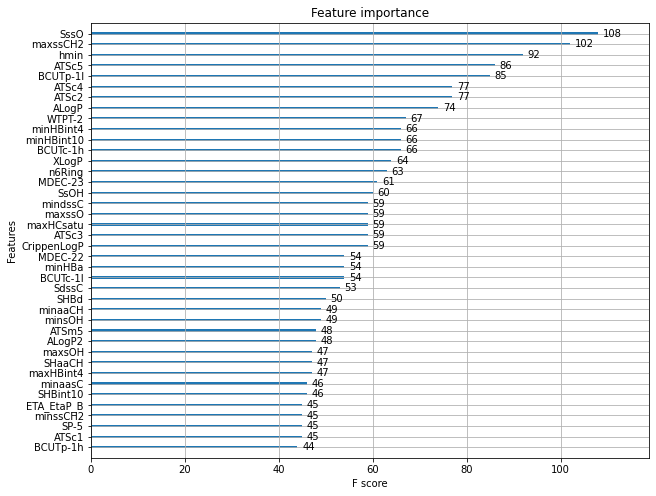

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(model_xgb, max_num_features=40, ax=ax)
# plt.figure(figsize=(96,72), dpi=100)
plt.savefig("./pictures/1xgboost_40.png")
plt.show()

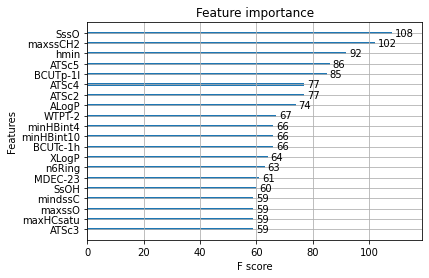

In [28]:
fig, ax = plt.subplots()
plot_importance(model_xgb, max_num_features=20, ax=ax)
# plt.figure(figsize=(96,72), dpi=120)
plt.savefig("./pictures/1xgboost_20.png")
plt.show()

In [29]:
importances = model_xgb.get_score()
# print(importances)
importances_sorted = sorted(importances.items(),key = lambda x:x[1],reverse = True)
# print(sorted(importances.items(),key = lambda x:x[1],reverse = True))

In [30]:
i = 0
importances_20_name = []
for item in importances_sorted:
    if i == 20:
        break
    importances_20_name.append(item[0])
    i += 1
print(importances_20_name)

i = 0
importances_40_name = []
for item in importances_sorted:
    if i == 40:
        break
    importances_40_name.append(item[0])
    i += 1
print(importances_40_name)

i = 0
importances_35_name = []
for item in importances_sorted:
    if i == 40:
        break
    importances_35_name.append(item[0])
    i += 1
print(importances_35_name)

['SssO', 'maxssCH2', 'hmin', 'ATSc5', 'BCUTp-1l', 'ATSc2', 'ATSc4', 'ALogP', 'WTPT-2', 'BCUTc-1h', 'minHBint10', 'minHBint4', 'XLogP', 'n6Ring', 'MDEC-23', 'SsOH', 'CrippenLogP', 'ATSc3', 'maxHCsatu', 'maxssO']
['SssO', 'maxssCH2', 'hmin', 'ATSc5', 'BCUTp-1l', 'ATSc2', 'ATSc4', 'ALogP', 'WTPT-2', 'BCUTc-1h', 'minHBint10', 'minHBint4', 'XLogP', 'n6Ring', 'MDEC-23', 'SsOH', 'CrippenLogP', 'ATSc3', 'maxHCsatu', 'maxssO', 'mindssC', 'BCUTc-1l', 'minHBa', 'MDEC-22', 'SdssC', 'SHBd', 'minsOH', 'minaaCH', 'ALogP2', 'ATSm5', 'maxHBint4', 'SHaaCH', 'maxsOH', 'SHBint10', 'minaasC', 'ATSc1', 'SP-5', 'minssCH2', 'ETA_EtaP_B', 'minHCsats']
['SssO', 'maxssCH2', 'hmin', 'ATSc5', 'BCUTp-1l', 'ATSc2', 'ATSc4', 'ALogP', 'WTPT-2', 'BCUTc-1h', 'minHBint10', 'minHBint4', 'XLogP', 'n6Ring', 'MDEC-23', 'SsOH', 'CrippenLogP', 'ATSc3', 'maxHCsatu', 'maxssO', 'mindssC', 'BCUTc-1l', 'minHBa', 'MDEC-22', 'SdssC', 'SHBd', 'minsOH', 'minaaCH', 'ALogP2', 'ATSm5', 'maxHBint4', 'SHaaCH', 'maxsOH', 'SHBint10', 'minaasC

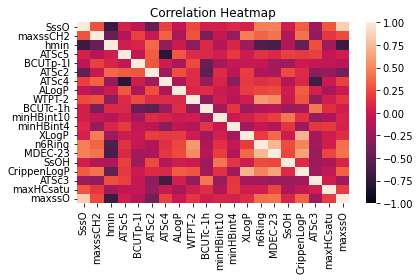

In [31]:
# ['SssO'1, 'hmin'2, 'ATSc5'3, 'maxssO'4, 'MDEC-23'5,'ATSc4'6, 'ATSc3'7, 
#  'XLogP'8, 'CrippenLogP'9, 'n6Ring'10, 'maxssCH2'11, 'minssCH2', 'SP-5', 'ATSc2', 'ATSc1'
#  , 'WTPT-2', 'ETA_EtaP_B', 'minHBint10', 'SHBint10', 'minHBint4', 'maxHBint4', 
#  'MDEC-22', 'SsOH', 'BCUTc-1l', 'mindssC', 'SdssC']

# 相关性分析。
# plt.figure(figsize=(18,14),dpi=80)
fig = sns.heatmap(x_data[importances_20_name].corr(), vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("./pictures/1correlation_heatmap_20.jpg")

In [32]:
# 通过强相关性的数据，需要将如下15个特征进行降维为9个.
x_data[importances_20_name].corr().to_csv("./data/1output_importances_20_corr.csv")
x_data[importances_40_name].corr().to_csv("./data/1output_importances_40_corr.csv")

# <a id='toc4_'></a>[强相关变量对](#toc0_)
|轮次|编号|强相关高权重特征|强相关低权重值特征|合成特征编号|
|---|---|---|---|---|
|1|1|SssO|hmin|f1|
|1|2|SssO|maxssO|f1|
|1|3|hmin|MDEC-23|f1|
|1|4|hmin|maxssO|f1|
|1|5|ATSc4|ATSc5|f2|
|1|6|ATSc4|ATSc3|f2|
|1|7|XLogP|CrippenLogP|f1|
|1|8|n6Ring|MDEC-23|f1|
|1|9|MDEC-23|CrippenLogP|f1|
|2|10|maxssCH2|minssCH2|f3|
|2|11|hmin|SP-5|f1|
|2|12|ATSc2|ATSc1|f4|
|2|13|WTPT-2|ETA_EtaP_B|f5|
|2|14|minHBint10|SHBint10|f6|
|2|15|minHBint4|maxHBint4|f7|
|2|16|n6Ring|SP-5|f1|
|2|17|MDEC-23|MDEC-22|f1|
|2|18|SsOH|BCUTc-1l|f8|
|2|19|mindssC|SdssC|f9|
|2|||||

In [33]:
# 需要被降维的列。
beforePCA_columns = ['SssO', 'hmin', 'ATSc5', 'maxssO', 'MDEC-23','ATSc4', 'ATSc3', 
                     'XLogP', 'CrippenLogP', 'n6Ring', 'maxssCH2', 'minssCH2', 'SP-5', 'ATSc2', 'ATSc1'
                     , 'WTPT-2', 'ETA_EtaP_B', 'minHBint10', 'SHBint10', 'minHBint4', 'maxHBint4', 
                     'MDEC-22', 'SsOH', 'BCUTc-1l', 'mindssC', 'SdssC']
print(len(beforePCA_columns))


# 删除强相关变量之后留下的新20个特征
new_columns_20 =['SssO', 'maxssCH2', 'ATSc5', 'BCUTp-1l', 'ATSc2', 
                 'ALogP', 'WTPT-2', 'BCUTc-1h', 'minHBint10', 'minHBint4', 
                 'XLogP', 'n6Ring',  'SsOH', 'ATSc3', 'maxHCsatu', 
                 'mindssC', 'BCUTc-1l', 'minHBa', 'MDEC-22','SdssC']
print(len(new_columns_20))

26
20


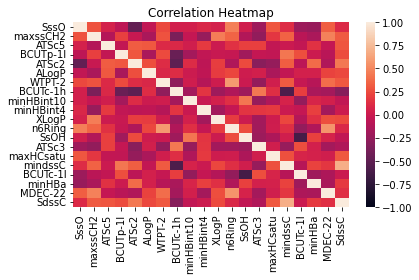

In [34]:
fig = sns.heatmap(x_data[new_columns_20].corr(), vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("./pictures/1correlation_heatmap_new_20.jpg")

In [35]:
(x_data.index).shape

(1974,)

D:\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24378 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 20851 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 21464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 25955 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Python37\lib\site-package

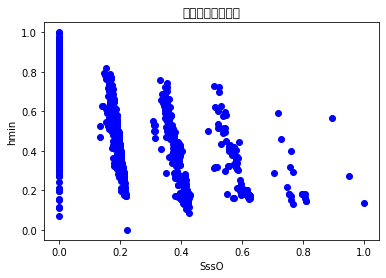

In [36]:
# 绘制散点图SssO|hmin
plt.scatter(x_data['SssO'], x_data['hmin'], c='b')
# plt.scatter(x_data.index, , c='orange')
# plt.plot(range(0,len(importance)),importance)
plt.title('强相关变量散点图')
plt.xlabel('SssO')
plt.ylabel('hmin')
# plt.grid()
plt.savefig('./pictures/1SssO_hmin.png', dpi=200)
plt.show()

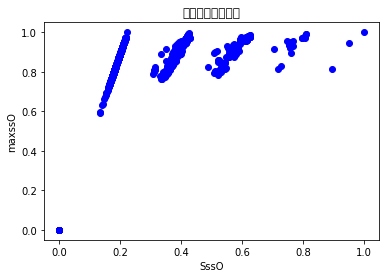

In [37]:
# 绘制散点图SssO|maxssO
plt.scatter(x_data['SssO'], x_data['maxssO'], c='b')
# plt.scatter(x_data.index, , c='orange')
# plt.plot(range(0,len(importance)),importance)
plt.title('强相关变量散点图')
plt.xlabel('SssO')
plt.ylabel('maxssO')
# plt.grid()
plt.savefig('./pictures/1SssO_maxssO.png', dpi=200)
plt.show()

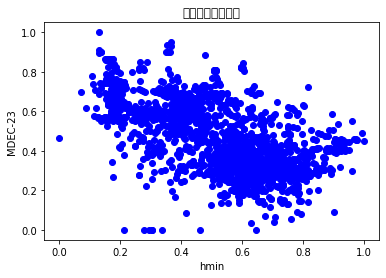

In [38]:
# hmin|MDEC-23
plt.scatter(x_data['hmin'], x_data['MDEC-23'], c='b')
# plt.scatter(x_data.index, , c='orange')
# plt.plot(range(0,len(importance)),importance)
plt.title('强相关变量散点图')
plt.xlabel('hmin')
plt.ylabel('MDEC-23')
# plt.grid()
plt.savefig('./pictures/1hmin_MDEC-23.png', dpi=200)
plt.show()

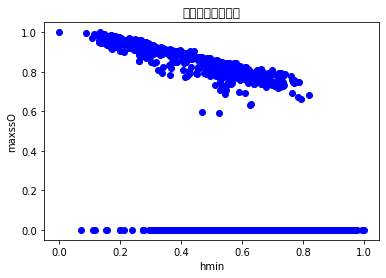

In [39]:
# hmin|maxssO
plt.scatter(x_data['hmin'], x_data['maxssO'], c='b')
# plt.scatter(x_data.index, , c='orange')
# plt.plot(range(0,len(importance)),importance)
plt.title('强相关变量散点图')
plt.xlabel('hmin')
plt.ylabel('maxssO')
# plt.grid()
plt.savefig('./pictures/1hmin_maxssO.png', dpi=200)
plt.show()

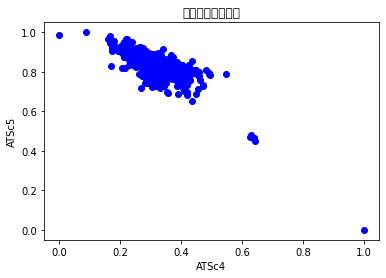

In [40]:
# ATSc4|ATSc5
plt.scatter(x_data['ATSc4'], x_data['ATSc5'], c='b')
plt.title('强相关变量散点图')
plt.xlabel('ATSc4')
plt.ylabel('ATSc5')
# plt.grid()
plt.savefig('./pictures/1ATSc4_ATSc5.png', dpi=200)
plt.show()

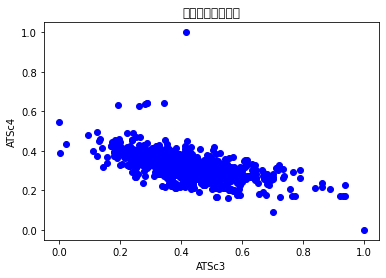

In [41]:
# ATSc4|ATSc3
plt.scatter(x_data['ATSc3'], x_data['ATSc4'], c='b')
plt.title('强相关变量散点图')
plt.xlabel('ATSc3')
plt.ylabel('ATSc4')
# plt.grid()
plt.savefig('./pictures/1ATSc3_ATSc4.png', dpi=200)
plt.show()

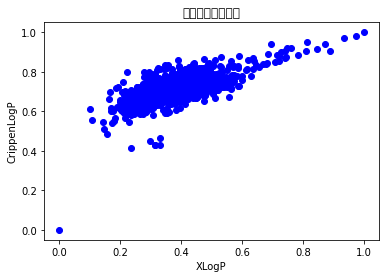

In [42]:
# XLogP|CrippenLogP
plt.scatter(x_data['XLogP'], x_data['CrippenLogP'], c='b')
plt.title('强相关变量散点图')
plt.xlabel('XLogP')
plt.ylabel('CrippenLogP')
# plt.grid()
plt.savefig('./pictures/1XLogP_CrippenLogP.png', dpi=200)
plt.show()

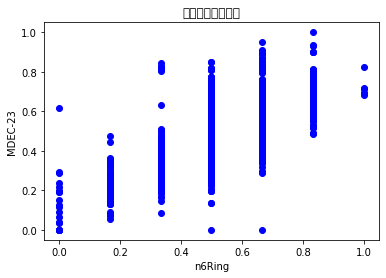

In [43]:
# n6Ring|MDEC-23
plt.scatter(x_data['n6Ring'], x_data['MDEC-23'], c='b')
plt.title('强相关变量散点图')
plt.xlabel('n6Ring')
plt.ylabel('MDEC-23')
# plt.grid()
plt.savefig('./pictures/1n6Ring_MDEC-23.png', dpi=200)
plt.show()

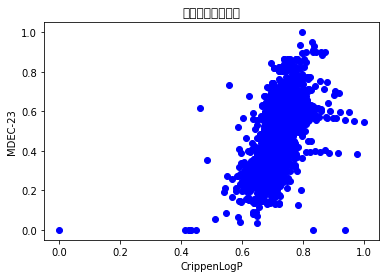

In [44]:
# MDEC-23|CrippenLogP
plt.scatter(x_data['CrippenLogP'], x_data['MDEC-23'], c='b')
plt.title('强相关变量散点图')
plt.xlabel('CrippenLogP')
plt.ylabel('MDEC-23')
# plt.grid()
plt.savefig('./pictures/1CrippenLogP_MDEC-23.png', dpi=200)
plt.show()

In [45]:
# beforePCA_columns=[1,3,5,3,4,4,2,9,6,7]
set_beforePCA_columns=set(beforePCA_columns)
#set会生成一个元素无序且不重复的可迭代对象，也就是我们常说的去重
if len(set_beforePCA_columns)==len(beforePCA_columns):
    print('列表里的元素互不重复！')
    x_beforePCA_data = x_data[beforePCA_columns].copy()
    print(len(beforePCA_columns))
else:
    print('列表里有重复的元素！')
    print(len(beforePCA_columns), len(set_beforePCA_columns))

列表里的元素互不重复！
26


# <a id='toc5_'></a>[有9个变量强相关，所以需要去掉强相关的变量。目前使用2个强相关特征，保留权重高的特征。](#toc0_)
- 还有个问题     我们的实验室的大神来了。  我问了问相关分析的逻辑和物理意义。     相关性分析  是因为后面需要做线性预测，线性预测里面要求变量之间不能强相关。    他推荐的用PCA将强相关变量降维 。
- 而且刚刚我看了几个强相关变量   其中hmin这个变量太特殊。权重值排第三  但是他和第一权重值的相关。  又和前二十中的其他几个权重值相关     不应该删除的。

In [46]:

pca_n_components = 9
pca = PCA(n_components = pca_n_components)
pca.fit(x_beforePCA_data)
print(pca.explained_variance_ratio_)

# 进行降维
principalComponents = pca.fit_transform(x_beforePCA_data)
# 查看降维后的数据
# columns=['principal component 1', 'principal component 2']
# 'f' + str(n) for n in range(pca_n_components)
after_pca_columns = [['f' + str(n) for n in range(pca_n_components)]]
principalDf = pd.DataFrame(data=principalComponents, columns=after_pca_columns)
print(principalDf.shape)
print(y_data.shape)
pcaFinalDf = pd.concat([principalDf, y_data], axis = 1)
pcaFinalDf.head(5)

[0.39902912 0.19009205 0.08440668 0.0669279  0.05773002 0.03707297
 0.02880925 0.02593571 0.01866951]
(1974, 9)
(1974,)


,"(f0,)","(f1,)","(f2,)","(f3,)","(f4,)","(f5,)","(f6,)","(f7,)","(f8,)",pIC50
0,0.895686,-0.197291,0.136763,-0.070699,-0.152146,-0.023091,-0.029690,-0.048608,0.013865,8.602
1,0.977942,-0.246143,0.054633,-0.090960,-0.206388,0.040508,-0.077444,-0.051365,0.038314,8.125
2,0.919100,-0.165008,-0.140859,-0.078037,0.151850,-0.017595,-0.031397,0.081711,-0.037713,8.509
3,0.996639,-0.264357,0.013710,-0.077611,-0.215159,0.021728,-0.010781,-0.058147,-0.006031,8.409
4,0.960723,-0.245994,0.003905,-0.089144,-0.228582,0.011302,-0.027313,-0.058685,-0.021316,8.131


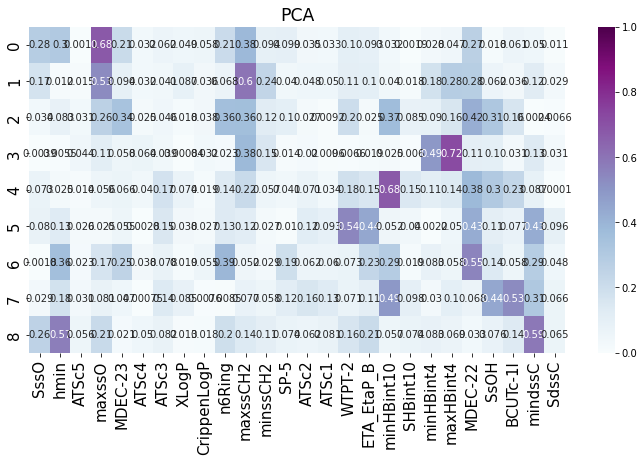

In [47]:
# 对系数进行可视化

# 如果对所有维度进行主成分分析，那么维度太大  运行时间太长，而且不利于最后的结果讨论。
# 采用了将其中某些特征进行主成分分析降维之后，然后再最后的结果讨论。
# 这里是对选择出来进行PCA的变量进行相关系可视化。
df_cm = pd.DataFrame(np.abs(pca.components_), columns=x_beforePCA_data.columns)
plt.figure(figsize = (12,6))
ax = sns.heatmap(df_cm, annot=True, cmap="BuPu",vmin=0, vmax=1)
# 设置y轴的字体的大小
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
plt.title('PCA', fontsize='xx-large')
# Set y-axis label
plt.savefig('./pictures/1beforePCAfactorAnalysis.png', dpi=200)
plt.show()

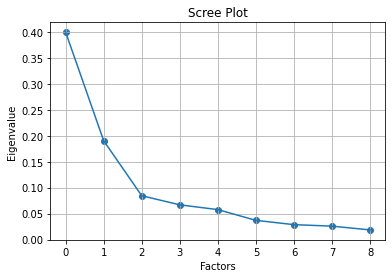

In [48]:
importance = pca.explained_variance_ratio_
len(importance)
plt.scatter(range(0,len(importance)),importance)
plt.plot(range(0,len(importance)),importance)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.savefig('./pictures/1explained_variance_ratio.png', dpi=200)
plt.show()

In [49]:
(pca.components_.shape)

(9, 26)

In [50]:
# 输出PCA的系数矩阵。
pca.components_

array([[ 2.82284735e-01, -3.01927240e-01, -1.05373963e-03,
         6.77831408e-01,  2.12910685e-01,  3.15995408e-02,
        -6.21428144e-02,  4.89798180e-02,  5.77197991e-02,
         2.09121947e-01,  3.84024750e-01,  9.39586865e-02,
         9.90286697e-02, -3.54484526e-02,  3.27649030e-02,
         1.01652453e-01, -9.34942782e-02,  3.19743144e-02,
         1.91974559e-03, -2.81117838e-02, -4.68700239e-02,
         2.67974601e-01,  1.82001000e-02, -6.09898129e-02,
         5.04185298e-02,  1.06748197e-02],
       [ 1.71284380e-01, -1.20606863e-02,  1.54766831e-02,
         5.33503101e-01, -9.38197296e-02, -3.15165165e-02,
         4.09048395e-02, -8.74311294e-02, -3.63867533e-02,
        -6.80332247e-02, -6.01350289e-01, -2.39312866e-01,
        -4.00529932e-02, -4.77073714e-02,  5.04351783e-02,
        -1.08344567e-01,  1.02116253e-01,  4.01525067e-02,
         1.75361844e-02,  1.77320227e-01,  2.84800120e-01,
        -2.78663932e-01,  6.22660666e-02, -3.55048667e-02,
        -1.22

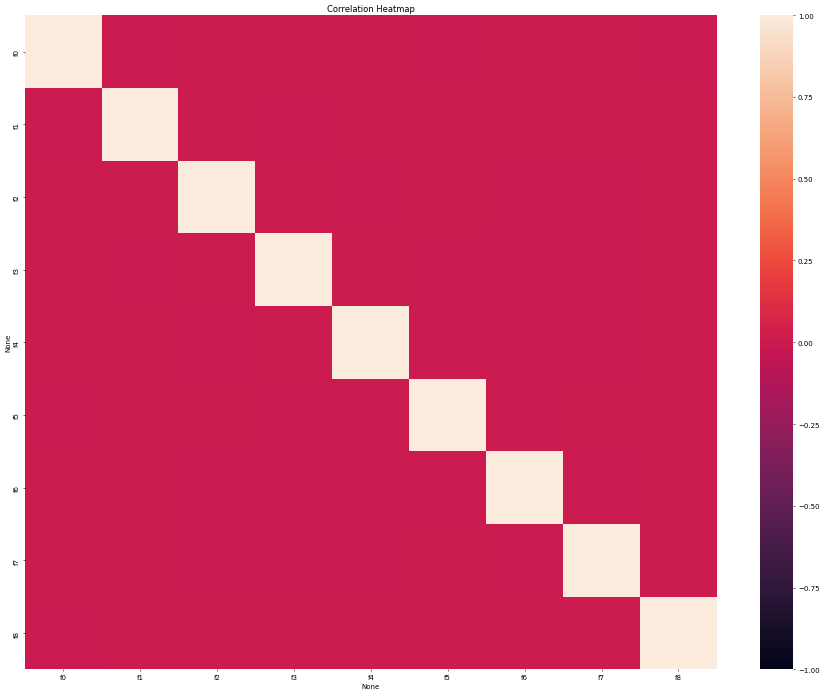

In [51]:
# 相关性分析。
# you can discover that resutl had problem. because the color is same in picture.
x_data_40 = x_data[importances_40_name].copy()

x_data_del_before_pca_40 = x_data_40.drop(beforePCA_columns, axis=1).copy()
# after_pca_40_data = pd.concat([x_data_del_before_pca_40 ,principalDf])
# after_pca_40_data = x_data_del_before_pca_40
after_pca_40_data = principalDf
plt.figure(figsize=(18,14),dpi=50)
fig = sns.heatmap(after_pca_40_data.corr(), vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("./pictures/correlation_heatmap_40.jpg")

after_pca_40_data.corr().to_csv("./data/output_after_pca_40_data.csv")

In [52]:
# 均方根误差计算。
def msesqrt(test_label, preds):
    squared_errors = [diff*diff for diff in (test_label - preds)]
    return math.sqrt(sum(squared_errors)/len(preds))

In [53]:
# 标签的最大值是10，最小值是2，均值6.58
msesqrt(ys_test, ans)

1.2320980600129234

In [54]:
# 绘图专用ys_test数据集。
ys_test_plt = ys_test.reset_index()
print(ys_test_plt.shape)
# print(ys_test_plt.columns)
# print(type(ys_test_plt))
ys_test_plt.drop(['index'], axis=1, inplace=True)
print(ys_test_plt.head())

(395, 2)
   pIC50
0  7.070
1  5.430
2  5.930
3  5.509
4  4.609


In [55]:
print(type(model_xgb))
# model_xgb.get_booster().get_score()

<class 'xgboost.core.Booster'>


In [56]:
# 其他的评价函数和评价结果
xgb_EVS = explained_variance_score(ys_test, ans)
xgb_MAE = mean_absolute_error(ys_test, ans)
xgb_MSE = mean_squared_error(ys_test, ans)
xgb_MedAE = median_absolute_error(ys_test, ans)
xgb_r2 = r2_score(ys_test, ans)
print('xgb_EVS: \t %f \nxgb_MAE: \t %f \nxgb_MSE: \t %f \nxgb_MedAE: \t %f \nxgb_r2: \t %f \n'%(xgb_EVS, xgb_MAE, xgb_MSE, xgb_MedAE, xgb_r2))

xgb_EVS: 	 0.248605 
xgb_MAE: 	 1.021131 
xgb_MSE: 	 1.518066 
xgb_MedAE: 	 0.978180 
xgb_r2: 	 0.238314 



In [57]:
print(type(ans))
# print(ans)
print(np.size(ans))
print(ys_test.shape)
print(ys_test)

<class 'numpy.ndarray'>
395
(395,)
1579    7.070
1580    5.430
1581    5.930
1582    5.509
1583    4.609
        ...  
1969    6.132
1970    5.851
1971    7.721
1972    7.886
1973    7.569
Name: pIC50, Length: 395, dtype: float64


In [58]:
# ROC曲线及相关的评价参数
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve

# <a id='toc6_'></a>[问题2](#toc0_)
对admet分类进行预测。

# <a id='toc7_'></a>[多种模型预测](#toc0_)
- 不能做的LogisticRegression、DecisionTreeClassifier决策树模型、SVC   SVM模型、GradientBoostingClassifier CBDT。
- 可以做的LinearRegression线性预测、CNN

In [59]:
xs_test.shape

(395, 729)

In [60]:
# 线性回归进行预测。
DisplayStartInfo()

lrg = LinearRegression() 
lrg.fit(xs_train,ys_train)
lrg_y_pre = lrg.predict(xs_test)
print(lrg_y_pre)
lrg_y_pre_pd = pd.DataFrame(lrg_y_pre)
# lrg_y_proba = lrg.predict(xs_test)LinearRegression

DisplayCompletedInfo()

-------------------------Start-------------------------
2021-10-20 09:58:00
[ 7.55810547e+00  5.96264648e+00  6.84375000e+00  2.89282227e+00
  5.17846680e+00  5.99829102e+00  5.06958008e+00  6.92431641e+00
  7.45751953e+00  8.61938477e+00  7.67919922e+00  6.96972656e+00
  7.78222656e+00  7.09252930e+00  7.80273438e+00  7.28442383e+00
  5.66552734e+00  5.67065430e+00  5.01513672e+00  6.11840820e+00
  6.25073242e+00  5.50830078e+00  5.66967773e+00  5.72705078e+00
  4.83349609e+00  7.30200195e+00  9.50390625e+00  9.09790039e+00
  7.66674805e+00  9.03442383e+00  9.84667969e+00  8.32153320e+00
  1.06594238e+01  9.15820312e+00  8.16870117e+00  8.78515625e+00
  6.97412109e+00  6.84912109e+00  7.40869141e+00  7.41625977e+00
  7.29125977e+00  7.48657227e+00  8.12792969e+00  8.05102539e+00
  7.30200195e+00  7.19824219e+00  7.19824219e+00  7.65283203e+00
  7.55493164e+00  7.67187500e+00  7.48657227e+00  8.79125977e+00
  8.80249023e+00  8.72875977e+00  9.06103516e+00  9.00170898e+00
  8.80566406e+

In [61]:
# 千万注意线性回归预测的时候，会出现特别异常的值，所以一定要进行异常值处理。并且导致绘图出现直线的情况。
i = 0
for index, row in lrg_y_pre_pd.iterrows():
    if row[0] < 2:
        row[0] = 2
        i += 1
    elif row[0] > 10:
        row[0] = 10
        i += 1
    else:
        pass
print(i)

26


In [62]:
lrg_y_pre_pd_plt = pd.DataFrame(lrg_y_pre_pd[0].apply(lambda x : float(format(x,'.3f'))))
print(lrg_y_pre_pd_plt.head())
print(type(lrg_y_pre_pd_plt))
print(lrg_y_pre_pd_plt.columns)
lrg_y_pre_pd_plt.rename(columns={0:'pIC50'}, inplace = True)

print(lrg_y_pre_pd_plt.head())
print(type(lrg_y_pre_pd_plt))
print(lrg_y_pre_pd_plt.columns)

print(type(lrg_y_pre))
print(lrg_y_pre)

       0
0  7.558
1  5.963
2  6.844
3  2.893
4  5.178
<class 'pandas.core.frame.DataFrame'>
Int64Index([0], dtype='int64')
   pIC50
0  7.558
1  5.963
2  6.844
3  2.893
4  5.178
<class 'pandas.core.frame.DataFrame'>
Index(['pIC50'], dtype='object')
<class 'numpy.ndarray'>
[ 7.55810547  5.96264648  6.84375     2.89282227  5.1784668   5.99829102
  5.06958008  6.92431641  7.45751953  8.61938477  7.67919922  6.96972656
  7.78222656  7.0925293   7.80273438  7.28442383  5.66552734  5.6706543
  5.01513672  6.1184082   6.25073242  5.50830078  5.66967773  5.72705078
  4.83349609  7.30200195  9.50390625  9.09790039  7.66674805  9.03442383
  9.84667969  8.3215332  10.          9.15820312  8.16870117  8.78515625
  6.97412109  6.84912109  7.40869141  7.41625977  7.29125977  7.48657227
  8.12792969  8.05102539  7.30200195  7.19824219  7.19824219  7.65283203
  7.55493164  7.671875    7.48657227  8.79125977  8.80249023  8.72875977
  9.06103516  9.00170898  8.80566406  8.94946289  7.82299805  8.06884766

In [63]:
print(ys_test_plt.head())
print(type(ys_test_plt))

   pIC50
0  7.070
1  5.430
2  5.930
3  5.509
4  4.609
<class 'pandas.core.frame.DataFrame'>


In [64]:
print(lrg_y_pre_pd.shape)
print(lrg_y_pre_pd.columns)
print(ans.shape)
print(type(ans))

(395, 1)
RangeIndex(start=0, stop=1, step=1)
(395,)
<class 'numpy.ndarray'>


In [65]:
for i in range(5):
    print(format(lrg_y_pre[i], '.3f'))

7.558
5.963
6.844
2.893
5.178


In [66]:
print(ys_test.shape)
print(ys_test)
print(type(ys_test))

(395,)
1579    7.070
1580    5.430
1581    5.930
1582    5.509
1583    4.609
        ...  
1969    6.132
1970    5.851
1971    7.721
1972    7.886
1973    7.569
Name: pIC50, Length: 395, dtype: float64
<class 'pandas.core.series.Series'>


In [67]:
lrg_EVS = explained_variance_score(ys_test, lrg_y_pre_pd)
lrg_MAE = mean_absolute_error(ys_test, lrg_y_pre_pd)
lrg_MSE = mean_squared_error(ys_test, lrg_y_pre_pd)
lrg_MedAE = median_absolute_error(ys_test, lrg_y_pre_pd)
lrg_r2 = r2_score(ys_test, lrg_y_pre_pd)
print('lrg_EVS: \t %f \nlrg_MAE: \t %f \nlrg_MSE: \t %f \nlrg_MedAE: \t %f \nlrg_r2: \t %f \n'%(lrg_EVS, lrg_MAE, lrg_MSE, lrg_MedAE, lrg_r2))

lrg_EVS: 	 -0.127543 
lrg_MAE: 	 1.153299 
lrg_MSE: 	 2.285962 
lrg_MedAE: 	 0.986654 
lrg_r2: 	 -0.146976 



In [68]:
unkownlist = []
for index, row in lrg_y_pre_pd_plt.iterrows():
    unkownlist.append(row[0].item())
print(unkownlist)

[7.558, 5.963, 6.844, 2.893, 5.178, 5.998, 5.07, 6.924, 7.458, 8.619, 7.679, 6.97, 7.782, 7.093, 7.803, 7.284, 5.666, 5.671, 5.015, 6.118, 6.251, 5.508, 5.67, 5.727, 4.833, 7.302, 9.504, 9.098, 7.667, 9.034, 9.847, 8.322, 10.0, 9.158, 8.169, 8.785, 6.974, 6.849, 7.409, 7.416, 7.291, 7.487, 8.128, 8.051, 7.302, 7.198, 7.198, 7.653, 7.555, 7.672, 7.487, 8.791, 8.802, 8.729, 9.061, 9.002, 8.806, 8.949, 7.823, 8.069, 8.849, 5.918, 6.824, 6.942, 6.907, 7.045, 6.794, 6.821, 4.572, 4.726, 5.024, 4.338, 4.333, 4.794, 4.687, 5.071, 4.601, 4.688, 7.042, 6.892, 6.994, 7.388, 7.769, 5.684, 5.684, 5.626, 6.002, 7.735, 7.323, 7.916, 6.761, 7.492, 7.782, 6.926, 7.131, 6.51, 6.803, 7.697, 7.678, 7.74, 7.681, 7.544, 7.861, 8.044, 7.581, 8.293, 7.968, 10.0, 8.312, 8.317, 8.403, 7.74, 8.453, 8.067, 9.826, 9.042, 7.647, 7.793, 7.836, 7.945, 7.777, 7.663, 7.351, 7.468, 7.603, 7.614, 7.789, 6.922, 6.931, 8.873, 8.476, 8.434, 8.314, 7.866, 7.769, 7.781, 7.609, 7.345, 7.521, 8.028, 6.846, 8.039, 7.732, 8.167,

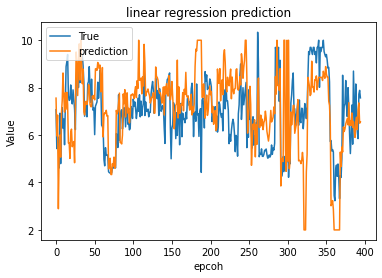

In [69]:
plt.plot(ys_test_plt)
plt.plot(lrg_y_pre_pd)
plt.title("linear regression prediction")
plt.ylabel('Value')
plt.xlabel("epcoh")
plt.legend(["True", "prediction"], loc="upper left")
plt.savefig("./pictures/2linear_regression.jpg")
plt.show()

In [70]:
print(type(ys_test_plt))
print(type(ans))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


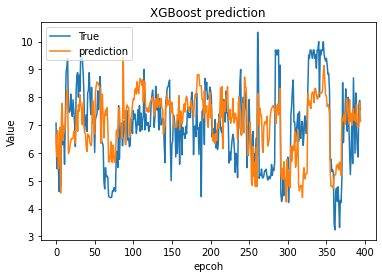

In [71]:
# 绘图
# ax2 = plt.figure(figsize=(20,10), dpi=30)
plt.plot(ys_test_plt)
plt.plot(ans)
plt.title("XGBoost prediction")
plt.ylabel('Value')
plt.xlabel("epcoh")
plt.legend(["True", "prediction"], loc="upper left")
plt.savefig("./pictures/2xgboostprediction.jpg")
plt.show()

In [72]:
# 其他的评价函数和评价结果
xgb_EVS = explained_variance_score(ys_test, ans)
xgb_MAE = mean_absolute_error(ys_test, ans)
xgb_MSE = mean_squared_error(ys_test, ans)
xgb_MedAE = median_absolute_error(ys_test, ans)
xgb_r2 = r2_score(ys_test, ans)
print('xgb_EVS: \t %f \nxgb_MAE: \t %f \nxgb_MSE: \t %f \nxgb_MedAE: \t %f \nxgb_r2: \t %f \n'%(xgb_EVS, xgb_MAE, xgb_MSE, xgb_MedAE, xgb_r2))

xgb_EVS: 	 0.248605 
xgb_MAE: 	 1.021131 
xgb_MSE: 	 1.518066 
xgb_MedAE: 	 0.978180 
xgb_r2: 	 0.238314 



In [73]:
# 保留日志，设置回调函数。
logdir = './tf_logs'
checkpoint_path = './checkpoint/PersonalCriePrediction.{epoch:02d}-{val_loss:.2f}.ckpt'

callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=2, profile_batch=100000000), 
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, 
                                                verbose=1, save_freq='epoch')]

input_dim_param = len(xs_train.columns)
print(input_dim_param)

DisplayStartInfo()

model_CNN = tf.keras.models.Sequential()
model_CNN.add(tf.keras.layers.Dense(units=256, input_dim=input_dim_param, 
                                    use_bias=True, kernel_initializer='uniform', 
                                    bias_initializer='zeros', activation='relu'))
# 增加平坦层。
model_CNN.add(tf.keras.layers.Flatten())
model_CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
# 设置了0.3的丢弃层。
model_CNN.add(tf.keras.layers.Dropout(0.3))
model_CNN.add(tf.keras.layers.Dense(units=16, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(units=1, activation='relu'))
model_CNN.summary()

# 0.001
# 优化器是RMSprop(0.003)
# 损失函数是mse 均方误差
# 衡量指标mae 平均绝对误差
model_CNN.compile(optimizer=tf.keras.optimizers.RMSprop(0.01), loss='mse', 
                  metrics=['mae'])
train_history_contain = model_CNN.fit(x=x_data, y=y_data, validation_split=0.2, 
                                      epochs=100, batch_size=20, verbose=2, callbacks=callbacks)

DisplayCompletedInfo()

729
-------------------------Start-------------------------
2021-10-20 09:58:02
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               186880    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 204,385
Trainable params: 20

In [74]:
def visu_train_histroy(train_history, train_metric, validation_metric):
    plt.plot(train_history.history[train_metric])
    plt.plot(train_history.history[validation_metric])
    plt.title("Train History")
    plt.ylabel(train_metric)
    plt.xlabel("epcoh")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig("./pictures/2NN_trainhistory.jpg")
    plt.show()

In [75]:
print(list(train_history_contain.history.keys()))

['loss', 'mae', 'val_loss', 'val_mae']


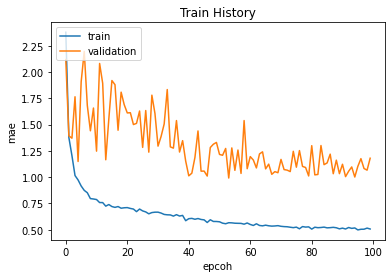

In [76]:
visu_train_histroy(train_history_contain, "mae", "val_mae")

In [77]:
evaluate_result_contain = model_CNN.evaluate(x=xs_test, y=ys_test)
print(model_CNN.metrics_names)
print(evaluate_result_contain)

13/13 [==============================] - 0s 1ms/step - loss: 2.1596 - mae: 1.1800
['loss', 'mae']
[2.15964937210083, 1.180021047592163]


In [78]:
surv_probability = model_CNN.predict(xs_test)

In [79]:
surv_probability

array([[6.32254  ],
       [6.2193346],
       [6.1187897],
       [4.5422463],
       [5.326985 ],
       [5.4097695],
       [4.5422463],
       [6.1722155],
       [6.3620005],
       [6.0834446],
       [6.2108345],
       [6.268875 ],
       [6.6331596],
       [6.4006295],
       [6.7275095],
       [6.499306 ],
       [4.695274 ],
       [5.173157 ],
       [5.7097626],
       [5.414713 ],
       [5.4841104],
       [5.859231 ],
       [5.3224463],
       [5.4410505],
       [5.804201 ],
       [5.708066 ],
       [6.343658 ],
       [6.811926 ],
       [5.9218965],
       [6.4851484],
       [7.051344 ],
       [5.7511816],
       [6.811488 ],
       [6.8775854],
       [5.7855034],
       [6.4357777],
       [5.055316 ],
       [5.029186 ],
       [5.745697 ],
       [5.636465 ],
       [5.6214213],
       [5.9614983],
       [5.7779713],
       [5.7571726],
       [5.708066 ],
       [5.7490044],
       [5.7490044],
       [5.5533743],
       [6.1585765],
       [6.0233903],


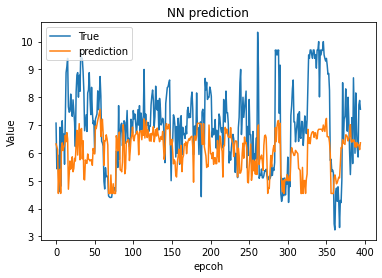

In [80]:
# 绘图
plt.plot(ys_test_plt)
plt.plot(surv_probability)
plt.title("NN prediction")
plt.ylabel('Value')
plt.xlabel("epcoh")
plt.legend(["True", "prediction"], loc="upper left")
plt.savefig("./pictures/2NNprediction.png")
plt.show()

In [81]:
# 其他的评价函数和评价结果
nn_EVS = explained_variance_score(ys_test, surv_probability)
nn_MAE = mean_absolute_error(ys_test, surv_probability)
nn_MSE = mean_squared_error(ys_test, surv_probability)
nn_MedAE = median_absolute_error(ys_test, surv_probability)
nn_r2 = r2_score(ys_test, surv_probability)
print('nn_EVS: \t %f \nnn_MAE: \t %f \nnn_MSE: \t %f \nnn_MedAE: \t %f \nnn_r2: \t %f \n'%(nn_EVS, nn_MAE, nn_MSE, nn_MedAE, nn_r2))

nn_EVS: 	 0.294581 
nn_MAE: 	 1.180021 
nn_MSE: 	 2.159650 
nn_MedAE: 	 0.979622 
nn_r2: 	 -0.083599 



# <a id='toc8_'></a>[refer information](#toc0_)
首先，这个问题的问法是有问题的，统计学的逻辑回归和机器学习的逻辑回归的目标不同，统计学中默认有一个潜在的规律，调模型时有各种限制来满足假设条件（VIF，线性相关就是这样），来找到那个潜在的规律，而机器学习不同，只关心预测值和真实值的偏差，甚至train和oot上的悬殊差别也能接受，只要oot上AUC越高，就可以。如果明白了这个差别，就不会问出这个问题了。

再详细讲模型类型和处理变量相关性之间的关系。

树模型，生成的时候更多考虑信息增益，所以说它天然带有剔除线性相关的特性，更进一步它也可以规避掉非线性的相关关系。至于为什么会出现我之前遇到的问题（数据不可已不可考查），是和数据大小变量多少有关，指定了树的大小，总是要矮子里面拔将军。下次遇到类似情况我可以验证一下


In [82]:
# 实际上pic50是ic50的负对数。
print(x_data.shape)
print(x_test.shape)

(1974, 729)
(50, 729)


In [83]:
y_data_pic50 = ERa_activity_origin['pIC50']
y_data_ic50 = ERa_activity_origin['IC50_nM']
print(y_data_pic50.shape)
print(y_data_ic50.shape)

(1974,)
(1974,)


In [84]:
x_data_20 = x_data[importances_20_name]
print(x_data_20.shape)

x_test_20 = x_test[importances_20_name]
print(x_test_20.shape)

(1974, 20)
(50, 20)


In [85]:
xgbParams = {
    'booster':'gbtree',
    'objective':'reg:linear',
    'gamma':0.1,
    'max_depth':6,
    'lambda':2,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'silent':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4
}

dtrain_pic50 = xgb.DMatrix(x_data_20, y_data_pic50)
plst = list(xgbParams.items())
# print(plst_dw)
num_rounds = 500
# , feature_names=list(x_feature_names)
model_xgb_pic50 = xgb.train(plst, dtrain_pic50, num_rounds)
dtest = xgb.DMatrix(x_test_20)
y_test_pic50 = model_xgb_pic50.predict(dtest)

DisplayCompletedInfo()

[09:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Completed at 2021-10-20 09:58:39.

-------------------------Completed-------------------------


In [86]:
pd.DataFrame(y_test_pic50).to_csv('./data/3predict_pic50.csv')

In [87]:
dtrain_ic50 = xgb.DMatrix(x_data_20, y_data_ic50)
plst = list(xgbParams.items())
# print(plst_dw)
num_rounds = 500
# , feature_names=list(x_feature_names)
model_xgb_ic50 = xgb.train(plst, dtrain_ic50, num_rounds)
dtest = xgb.DMatrix(x_test_20)
y_test_ic50 = model_xgb_ic50.predict(dtest)

DisplayCompletedInfo()

[09:58:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Completed at 2021-10-20 09:58:40.

-------------------------Completed-------------------------


In [88]:
pd.DataFrame(y_test_ic50).to_csv('./data/predict_ic50.csv')

In [89]:
y_result = pd.read_csv("./data/ERa_activity_test.csv")
print(y_result.shape)
# print(y_result.head())
y_result['pIC50'] = y_test_pic50
print(y_result.head())

def CalculateIC50BypIC50(input):
    return pow(10, (-input + 9))

y_result['IC50_nM'] = y_result['pIC50'].apply(lambda x : CalculateIC50BypIC50(x))

print(y_result.head())

(50, 3)
                                              SMILES  IC50_nM     pIC50
0  COc1cc(OC)cc(\C=C\c2ccc(OS(=O)(=O)[C@@H]3C[C@@...      NaN  6.605861
1  OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3ccccc23)c4ccc(O...      NaN  6.563363
2  COc1ccc2C(=C(CCOc2c1)c3ccc(O)cc3)c4ccc(\C=C\C(...      NaN  6.689188
3  OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc23)c4cc...      NaN  7.255666
4  OC(=O)\C=C\c1ccc(cc1)C2=C(CCSc3cc(F)ccc23)c4cc...      NaN  7.727409
                                              SMILES     IC50_nM     pIC50
0  COc1cc(OC)cc(\C=C\c2ccc(OS(=O)(=O)[C@@H]3C[C@@...  247.821676  6.605861
1  OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3ccccc23)c4ccc(O...  273.298597  6.563363
2  COc1ccc2C(=C(CCOc2c1)c3ccc(O)cc3)c4ccc(\C=C\C(...  204.555669  6.689188
3  OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc23)c4cc...   55.505209  7.255666
4  OC(=O)\C=C\c1ccc(cc1)C2=C(CCSc3cc(F)ccc23)c4cc...   18.732300  7.727409


# <a id='toc9_'></a>[问题3 分类预测](#toc0_)
# <a id='toc10_'></a>[XGBOOST进行预测](#toc0_)

In [90]:
# 将标签列处理好。
y_caco2 = pd.DataFrame(admet_origin['Caco-2']).copy()
y_caco2.rename(columns={0:'Caco-2label'}, inplace = True)
print(y_caco2.head(30))

y_CYP3A4 = pd.DataFrame(admet_origin['CYP3A4']).copy()
y_CYP3A4.rename(columns={0:'CYP3A4label'}, inplace = True)

y_hERG = pd.DataFrame(admet_origin['hERG']).copy()
y_hERG.rename(columns={0:'hERGlabel'}, inplace = True)
y_HOB = pd.DataFrame(admet_origin['HOB']).copy()
y_HOB.rename(columns={0:'HOBlabel'}, inplace = True)
y_MN = pd.DataFrame(admet_origin['MN']).copy()
y_MN.rename(columns={0:'MNlabel'}, inplace = True)
print(y_MN.head())

    Caco-2
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       1
12       1
13       0
14       0
15       1
16       0
17       1
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
   MN
0   0
1   0
2   1
3   0
4   0


In [91]:
# 首先查看样本情况
# obj2[obj2.values == 7].index
print("caco2 :")
print(admet_origin['Caco-2'].value_counts())
DisplaySeparator()

print("CYP3A4 :")
print(admet_origin['CYP3A4'].value_counts())
DisplaySeparator()

print("hERG :")
print(admet_origin['hERG'].value_counts())
DisplaySeparator()

print("HOB :")
print(admet_origin['HOB'].value_counts())
DisplaySeparator()

print("MN :")
print(admet_origin['MN'].value_counts())

caco2 :
0    1215
1     759
Name: Caco-2, dtype: int64
---------------------------------------------------------

CYP3A4 :
1    1461
0     513
Name: CYP3A4, dtype: int64
---------------------------------------------------------

hERG :
1    1099
0     875
Name: hERG, dtype: int64
---------------------------------------------------------

HOB :
0    1465
1     509
Name: HOB, dtype: int64
---------------------------------------------------------

MN :
1    1514
0     460
Name: MN, dtype: int64


In [92]:
y_caco2.head(30)

,Caco-2
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [93]:
# 按列合并。
samples_caco2 = pd.concat([x_data, y_caco2], axis=1)
samples_CYP3A4 = pd.concat([x_data, y_CYP3A4], axis=1)
samples_hERG = pd.concat([x_data, y_hERG], axis=1)
samples_HOB = pd.concat([x_data, y_HOB], axis=1)
samples_MN = pd.concat([x_data, y_MN], axis=1)
print(samples_caco2.head(30))

    nAcid     ALogP    ALogP2       AMR      apol  naAromAtom  nAromBond  \
0     0.0  0.806704  0.000153  0.155498  0.132244    0.400000   0.352941   
1     0.0  0.786341  0.001392  0.168065  0.151050    0.400000   0.352941   
2     0.0  0.842608  0.000997  0.185305  0.131924    0.600000   0.529412   
3     0.0  0.805559  0.000190  0.171389  0.151050    0.400000   0.352941   
4     0.0  0.864721  0.003440  0.192340  0.138889    0.600000   0.529412   
5     0.0  0.802953  0.000288  0.174137  0.125453    0.600000   0.529412   
6     0.0  0.870391  0.004302  0.190478  0.140774    0.600000   0.529412   
7     0.0  0.813230  0.000019  0.162611  0.117171    0.566667   0.500000   
8     0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
9     0.0  0.869165  0.004108  0.125867  0.067967    0.600000   0.529412   
10    0.0  0.819484  0.000011  0.193694  0.137542    0.600000   0.529412   
11    0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
12    0.0  0

In [94]:
def balanceData(originData, samples, labelname):
    label_0 = originData[labelname].value_counts()[0]
    label_1 = originData[labelname].value_counts()[1]
    # print(label_0, label_1)
    if label_0 > label_1 :
        samples_Label0 = samples.loc[samples[labelname]==0].sample(n=label_1, random_state=1)
        samples_Label1 = samples.loc[samples[labelname]==1]
        # print(samples_Label0.head())
        # print(samples_Label1.head())
        # 按行合并。
        samples_final = pd.concat([samples_Label0, samples_Label1]).sample(frac=1)
    elif label_0 < label_1:
        samples_Label0 = samples.loc[samples[labelname]==0]
        samples_Label1 = samples.loc[samples[labelname]==1].sample(n=label_0, random_state=1)
        samples_final = pd.concat([samples_Label0, samples_Label1]).sample(frac=1)
    else:
        samples_final = samples.copy()
    print(samples_final.head())
    return samples_final
    

In [95]:
samples_caco2.head()

,nAcid,ALogP,ALogP2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Caco-2
0,0.0,0.806704,0.000153,0.155498,0.132244,0.4,0.352941,0.133540,0.114094,0.160000,...,0.129255,0.755453,0.072142,0.174406,0.027093,0.008834,0.152778,0.461986,0.151603,0
1,0.0,0.786341,0.001392,0.168065,0.151050,0.4,0.352941,0.152174,0.127517,0.182857,...,0.143653,0.756796,0.072228,0.174502,0.027093,0.010510,0.185185,0.525650,0.163265,0
2,0.0,0.842608,0.000997,0.185305,0.131924,0.6,0.529412,0.127329,0.127517,0.137143,...,0.142927,0.727026,0.086238,0.224244,0.027093,0.010596,0.175926,0.366769,0.166181,0
3,0.0,0.805559,0.000190,0.171389,0.151050,0.4,0.352941,0.152174,0.127517,0.182857,...,0.143390,0.746032,0.072125,0.174387,0.027093,0.010769,0.166667,0.537455,0.163265,0
4,0.0,0.864721,0.003440,0.192340,0.138889,0.6,0.529412,0.133540,0.127517,0.148571,...,0.143390,0.746032,0.072125,0.174387,0.027093,0.010769,0.166667,0.450573,0.163265,0


In [96]:
x_caco2_data = balanceData(admet_origin, samples_caco2, 'Caco-2')
x_CYP3A4_data = balanceData(admet_origin, samples_CYP3A4, 'CYP3A4')
x_hERG_data = balanceData(admet_origin, samples_hERG, 'hERG')
x_HOB_data = balanceData(admet_origin, samples_HOB, 'HOB')
x_MN_data = balanceData(admet_origin, samples_MN, 'MN')

     nAcid     ALogP    ALogP2       AMR      apol  naAromAtom  nAromBond  \
526    0.0  0.811293  0.000046  0.138741  0.112926         0.4   0.352941   
295    0.0  0.821082  0.000027  0.056068  0.020784         0.5   0.500000   
701    0.0  0.887937  0.007582  0.043105  0.018680         0.4   0.382353   
897    0.0  0.808719  0.000098  0.194202  0.130803         0.7   0.676471   
531    0.0  0.907734  0.012390  0.175246  0.117134         0.6   0.529412   

        nAtom  nHeavyAtom        nH  ...    WTPT-1    WTPT-2    WTPT-3  \
526  0.121118    0.100671  0.148571  ...  0.112314  0.635163  0.071228   
295  0.031056    0.040268  0.034286  ...  0.046870  0.526768  0.061633   
701  0.027950    0.026846  0.040000  ...  0.033410  0.569421  0.031928   
897  0.124224    0.127517  0.131429  ...  0.142716  0.718375  0.086105   
531  0.118012    0.107383  0.137143  ...  0.122348  0.767877  0.057568   

       WTPT-4    WTPT-5     WPATH      WPOL     XLogP    Zagreb  Caco-2  
526  0.110607  0.0

In [97]:
xa_caco2_train, xa_caco2_test, ya_caco2_train, ya_caco2_test = train_test_split(x_caco2_data.iloc[:,:-1], x_caco2_data['Caco-2'], test_size=0.2, random_state=2020, shuffle=False)
xa_CYP3A4_train, xa_CYP3A4_test, ya_CYP3A4_train, ya_CYP3A4_test = train_test_split(x_CYP3A4_data.iloc[:,:-1], x_CYP3A4_data['CYP3A4'], test_size=0.2, random_state=2020, shuffle=False)
xa_hERG_train, xa_chERG_test, ya_hERG_train, ya_hERG_test = train_test_split(x_hERG_data.iloc[:,:-1], x_hERG_data['hERG'], test_size=0.2, random_state=2020, shuffle=False)
xa_HOB_train, xa_HOB_test, ya_HOB_train, ya_HOB_test = train_test_split(x_HOB_data.iloc[:,:-1], x_HOB_data['HOB'], test_size=0.2, random_state=2020, shuffle=False)
xa_MN_train, xa_MN_test, ya_MN_train, ya_MN_test = train_test_split(x_MN_data.iloc[:,:-1], x_MN_data['MN'], test_size=0.2, random_state=2020, shuffle=False)

# <a id='toc11_'></a>[对caco](#toc0_)

In [98]:
xgbParams = {
    'booster':'gbtree',
    'objective':'multi:softmax',
    'gamma':0.1,
    'num_class':2,
    'max_depth':6,
    'lambda':2,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'silent':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4
}

dtrain_caco2 = xgb.DMatrix(xa_caco2_train, ya_caco2_train)
plst = list(xgbParams.items())
num_rounds = 500
model_xgb_caco2 = xgb.train(plst, dtrain_caco2, num_rounds)
dtest_caco2 = xgb.DMatrix(xa_caco2_test)
y_pre_caco2 = model_xgb_caco2.predict(dtest_caco2)

DisplayCompletedInfo()

[09:58:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:58:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Completed at 2021-10-20 09:58:53.

-------------------------Completed-------------------------


In [99]:
print(y_pre_caco2)

[0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0.]


143 12 12 137
Accuracy 准确度: 92.11 %
Precision 精度: 92.26 %
Recall 召回率: 92.26 %
TP_dw=143. TN_dw=137. FN_dw=12. FP_dw=12


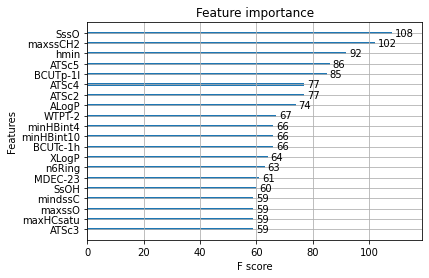

In [100]:
TP=0
FP=0
FN=0
TN=0
for i in range(len(ya_caco2_test)):
    if y_pre_caco2[i] == ya_caco2_test.values[i] == 1:
        TP += 1
    elif y_pre_caco2[i] == ya_caco2_test.values[i] == 0:
        TN += 1
    elif (y_pre_caco2[i] == 0 and ya_caco2_test.values[i]==1):
        FN += 1
    elif (y_pre_caco2[i] == 1 and ya_caco2_test.values[i]==0):
        FP += 1

print(TP, FP, FN, TN)
# print("Accuracy1 准确度1: %.2f %%"%(100*((TP + TN) / (FP + FN))))
print("Accuracy 准确度: %.2f %%"%(100*((TP + TN) / (TP + FP + FN + TN))))
print("Precision 精度: %.2f %%"%(100* (TP / (TP + FP))))
print("Recall 召回率: %.2f %%"%(100* (TP / (TP + FN))))
print("TP_dw=" + str(TP) + ". TN_dw=" + str(TN) + ". FN_dw=" + str(FN) + ". FP_dw=" + str(FP))
# 图片设置大小完成。figsize=(20,10), dpi=30
fig, ax = plt.subplots()
plot_importance(model_xgb, max_num_features=20, ax=ax)
# plt.figure(figsize=(20,10), dpi=80)
plt.savefig("./pictures/3xgboost_model_Featureimportance20.jpg")
plt.show()

In [101]:
# ROC曲线及相关的评价参数
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve
fpr,tpr,threshold = metrics.roc_curve(ya_caco2_test,y_pre_caco2)
xgb_roc_auc = metrics.auc(fpr, tpr)

# 其他的评价函数和评价结果
xgb_accuracy_score = accuracy_score(ya_caco2_test, y_pre_caco2)
xgb_preci_scorc = precision_score(ya_caco2_test, y_pre_caco2)
xgb_recall_score = recall_score(ya_caco2_test, y_pre_caco2)
xgb_f1_score = f1_score(ya_caco2_test, y_pre_caco2)
xgb_roc_auc_score = roc_auc_score(ya_caco2_test, y_pre_caco2)
print('xgb_accuracy_score: \t %f \nxgb_preci_scorc: \t %f \nxgb_recall_score: \t %f \nxgb_f1_score: \t %f \nxgb_roc_auc_score: \t %f \n'%(xgb_accuracy_score, xgb_preci_scorc, xgb_recall_score, xgb_f1_score, xgb_roc_auc_score))

xgb_accuracy_score: 	 0.921053 
xgb_preci_scorc: 	 0.922581 
xgb_recall_score: 	 0.922581 
xgb_f1_score: 	 0.922581 
xgb_roc_auc_score: 	 0.921022 



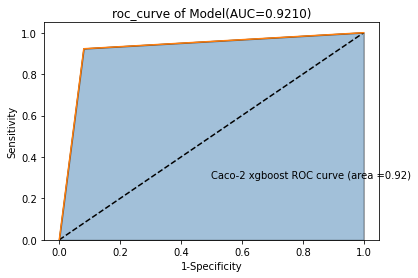

In [102]:
Xgbc_fpr,Xgbc_tpr,Xgbc_threasholds=roc_curve(ya_caco2_test,y_pre_caco2)

# 绘制面积图
plt.stackplot(Xgbc_fpr,Xgbc_tpr,color='steelblue', alpha=0.5, edgecolor='black')
# 添加标题名
plt.title('roc_curve of %s(AUC=%.4f)'%('Model', xgb_roc_auc))
# 添加边际线
plt.plot(Xgbc_fpr, Xgbc_tpr, color='black', lw=1)
# 添加对角线
plt.plot([0,1], [0,1], color='black', linestyle='--')
# 添加文本信息
plt.text(0.5, 0.3, 'Caco-2 xgboost ROC curve (area =%0.2f)'%xgb_roc_auc)
# 添加X轴和Y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.plot(Xgbc_fpr,Xgbc_tpr)
plt.savefig("./pictures/3xgboost_model_ROC.jpg")

plt.show()

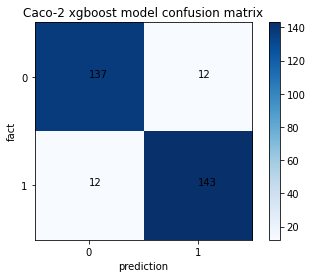

In [103]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

classes = list(set(ya_caco2_test))
classes.sort()

confusion = confusion_matrix(ya_caco2_test, y_pre_caco2)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('prediction')
plt.ylabel('fact')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.title("Caco-2 xgboost model confusion matrix")
plt.savefig("./pictures/3xgboost_model_confusion_matrix.jpg")
plt.show()

# <a id='toc12_'></a>[CYP3A4](#toc0_)

In [104]:
DisplayStartInfo()

svm = SVC(probability=True,random_state=2018,tol=1e-6)  # SVM模型
svm.fit(xa_CYP3A4_train, ya_CYP3A4_train)
svm_y_pre=svm.predict(xa_CYP3A4_test)
svm_y_proba=svm.predict_proba(xa_CYP3A4_test)

DisplayCompletedInfo()

-------------------------Start-------------------------
2021-10-20 09:58:54
Completed at 2021-10-20 09:58:55.

-------------------------Completed-------------------------


In [105]:
fpr,tpr,threshold = metrics.roc_curve(ya_CYP3A4_test,svm_y_pre)
xgb_roc_auc = metrics.auc(fpr, tpr)

svm_accuracy_score=accuracy_score(ya_CYP3A4_test,svm_y_pre)
svm_preci_score=precision_score(ya_CYP3A4_test,svm_y_pre)
svm_recall_score=recall_score(ya_CYP3A4_test,svm_y_pre)
svm_f1_score=f1_score(ya_CYP3A4_test,svm_y_pre)
svm_auc=roc_auc_score(ya_CYP3A4_test,svm_y_proba[:,1])
print('svm_accuracy_score: %f,svm_preci_score: %f,svm_recall_score: %f,svm_f1_score: %f,svm_auc: %f'
      %(svm_accuracy_score,svm_preci_score,svm_recall_score,svm_f1_score,svm_auc))

svm_accuracy_score: 0.917476,svm_preci_score: 0.990291,svm_recall_score: 0.864407,svm_f1_score: 0.923077,svm_auc: 0.974576


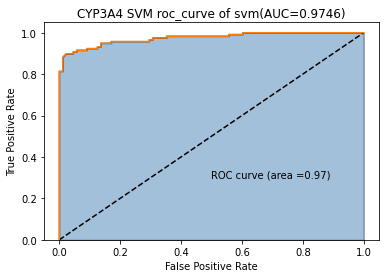

In [106]:
svm_fpr,svm_tpr,svm_threasholds=roc_curve(ya_CYP3A4_test,svm_y_proba[:,1]) # 计算ROC的值,svm_threasholds为阈值
plt.title("CYP3A4 SVM roc_curve of %s(AUC=%.4f)" %('svm',svm_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# 绘制面积图
plt.stackplot(svm_fpr,svm_tpr,color='steelblue', alpha=0.5, edgecolor='black')
# 添加对角线
plt.plot([0,1], [0,1], color='black', linestyle='--')
# 添加边际线
plt.plot(svm_fpr, svm_tpr, color='black', lw=1)
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area =%0.2f)'%svm_auc)
# plt.plot(svm_fpr, svm_tpr)
plt.plot(svm_fpr,svm_tpr)
plt.savefig("./pictures/3SVM__CYP3A4.jpg")
plt.show()

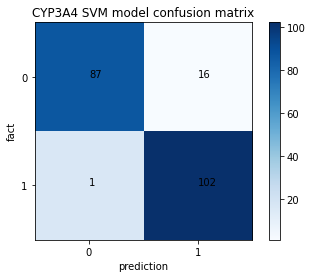

In [107]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

classes = list(set(ya_CYP3A4_test))
classes.sort()

confusion = confusion_matrix(ya_CYP3A4_test, svm_y_pre)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('prediction')
plt.ylabel('fact')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.title("CYP3A4 SVM model confusion matrix")
plt.savefig("./pictures/3SVM_model_confusion_matrix.jpg")
plt.show()

# <a id='toc13_'></a>[对chERG](#toc0_)

In [108]:
# xa_hERG_train, xa_chERG_test, ya_hERG_train, ya_hERG_test
DisplayStartInfo()

lr = LogisticRegression(random_state=2018,tol=1e-6)  # 逻辑回归模型
lr.fit(xa_hERG_train, ya_hERG_train)
lr_chERG_y_pre = lr.predict(xa_chERG_test)
lr_chERG_y_proba = lr.predict_proba(xa_chERG_test)

DisplayCompletedInfo()

-------------------------Start-------------------------
2021-10-20 09:58:55
Completed at 2021-10-20 09:58:56.

-------------------------Completed-------------------------


D:\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [109]:
lr_score = lr.score(xa_chERG_test, ya_hERG_test)
lr_accuracy_score = accuracy_score(ya_hERG_test,lr_chERG_y_pre)
lr_preci_score = precision_score(ya_hERG_test,lr_chERG_y_pre)
lr_recall_score = recall_score(ya_hERG_test,lr_chERG_y_pre)
lr_f1_score = f1_score(ya_hERG_test,lr_chERG_y_pre)
lr_auc = roc_auc_score(ya_hERG_test,lr_chERG_y_proba[:,1])
print('lr_accuracy_score: %f,lr_preci_score: %f,lr_recall_score: %f,lr_f1_score: %f,lr_auc: %f'
      %(lr_accuracy_score,lr_preci_score,lr_recall_score,lr_f1_score,lr_auc))

lr_accuracy_score: 0.848571,lr_preci_score: 0.831250,lr_recall_score: 0.836478,lr_f1_score: 0.833856,lr_auc: 0.929369


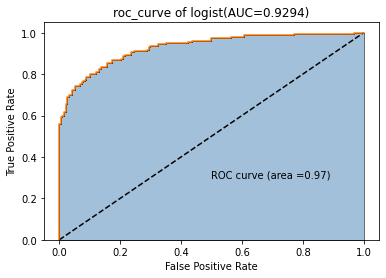

In [110]:
lr_fpr,lr_tpr,lr_threasholds=roc_curve(ya_hERG_test,lr_chERG_y_proba[:,1]) # 计算ROC的值,lr_threasholds为阈值
plt.title("roc_curve of %s(AUC=%.4f)" %('logist',lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 绘制面积图
plt.stackplot(lr_fpr,lr_tpr,color='steelblue', alpha=0.5, edgecolor='black')
# 添加对角线
plt.plot([0,1], [0,1], color='black', linestyle='--')
# 添加边际线
plt.plot(lr_fpr, lr_tpr, color='black', lw=1)
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area =%0.2f)'%svm_auc)
# plt.plot(svm_fpr, svm_tpr)
plt.savefig("./pictures/3lr__hERG.jpg")

plt.plot(lr_fpr,lr_tpr)
plt.show()

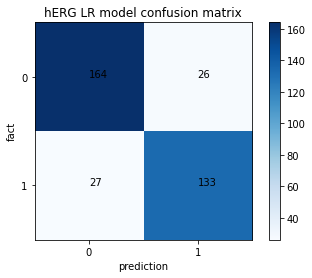

In [111]:
classes = list(set(ya_hERG_test))
classes.sort()

confusion = confusion_matrix(ya_hERG_test, lr_chERG_y_pre)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('prediction')
plt.ylabel('fact')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.title("hERG LR model confusion matrix")
plt.savefig("./pictures/3hERG_LR_model_confusion_matrix.jpg")
plt.show()

# <a id='toc14_'></a>[对HOB](#toc0_)

In [112]:
# xa_HOB_train, xa_HOB_test, ya_HOB_train, ya_HOB_test 
DisplayStartInfo()

tr = DecisionTreeClassifier(random_state=2018)  # 决策树模型
tr.fit(xa_HOB_train, ya_HOB_train)
tr_HOB_y_pre = tr.predict(xa_HOB_test)
tr_HOB_y_proba = tr.predict_proba(xa_HOB_test)

DisplayCompletedInfo()

-------------------------Start-------------------------
2021-10-20 09:58:56
Completed at 2021-10-20 09:58:56.

-------------------------Completed-------------------------


In [113]:
tr_score = tr.score(xa_HOB_test, ya_HOB_test)
tr_accuracy_score=accuracy_score(ya_HOB_test,tr_HOB_y_pre)
tr_preci_score=precision_score(ya_HOB_test,tr_HOB_y_pre)
tr_recall_score=recall_score(ya_HOB_test,tr_HOB_y_pre)
tr_f1_score=f1_score(ya_HOB_test,tr_HOB_y_pre)
tr_auc=roc_auc_score(ya_HOB_test,tr_HOB_y_proba[:,1])
print('tr_accuracy_score: %f,tr_preci_score: %f,tr_recall_score: %f,tr_f1_score: %f,tr_auc: %f'
      %(tr_accuracy_score,tr_preci_score,tr_recall_score,tr_f1_score,tr_auc))

tr_accuracy_score: 0.764706,tr_preci_score: 0.780952,tr_recall_score: 0.766355,tr_f1_score: 0.773585,tr_auc: 0.764621


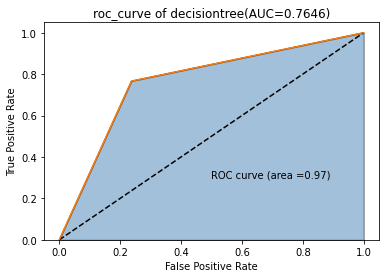

In [114]:
tr_fpr,tr_tpr,tr_threasholds=roc_curve(ya_HOB_test, tr_HOB_y_proba[:,1]) # 计算ROC的值,lr_threasholds为阈值
plt.title("roc_curve of %s(AUC=%.4f)" %('decisiontree',tr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 绘制面积图
plt.stackplot(tr_fpr,tr_tpr,color='steelblue', alpha=0.5, edgecolor='black')
# 添加对角线
plt.plot([0,1], [0,1], color='black', linestyle='--')
# 添加边际线
plt.plot(tr_fpr, tr_tpr, color='black', lw=1)
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area =%0.2f)'%svm_auc)
# plt.plot(svm_fpr, svm_tpr)
plt.savefig("./pictures/3tr__HOB.jpg")

plt.plot(tr_fpr,tr_tpr)
plt.show()

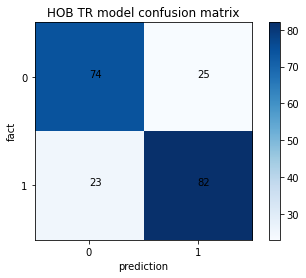

In [115]:
classes = list(set(ya_HOB_test))
classes.sort()

confusion = confusion_matrix(ya_HOB_test, tr_HOB_y_pre)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('prediction')
plt.ylabel('fact')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.title("HOB TR model confusion matrix")
plt.savefig("./pictures/3HOB_TR_model_confusion_matrix.jpg")
plt.show()

# <a id='toc15_'></a>[对MN](#toc0_)

In [116]:
# xa_MN_train, xa_MN_test, ya_MN_train, ya_MN_test
DisplayStartInfo()

forest = RandomForestClassifier(n_estimators=100,random_state=2018) #　随机森林
forest.fit(xa_MN_train,ya_MN_train)
forest_MN_y_pre = forest.predict(xa_MN_test)
forest_MN_y_proba = forest.predict_proba(xa_MN_test)

DisplayCompletedInfo()

-------------------------Start-------------------------
2021-10-20 09:58:57
Completed at 2021-10-20 09:58:58.

-------------------------Completed-------------------------


In [117]:
forest_accuracy_score=accuracy_score(ya_MN_test,forest_MN_y_pre)
forest_preci_score=precision_score(ya_MN_test,forest_MN_y_pre)
forest_recall_score=recall_score(ya_MN_test,forest_MN_y_pre)
forest_f1_score=f1_score(ya_MN_test,forest_MN_y_pre)
forest_auc=roc_auc_score(ya_MN_test,forest_MN_y_proba[:,1])
print('forest_accuracy_score: %f,forest_preci_score: %f,forest_recall_score: %f,forest_f1_score: %f,forest_auc: %f'
      %(forest_accuracy_score,forest_preci_score,forest_recall_score,forest_f1_score,forest_auc))

forest_accuracy_score: 0.940217,forest_preci_score: 0.945055,forest_recall_score: 0.934783,forest_f1_score: 0.939891,forest_auc: 0.973240


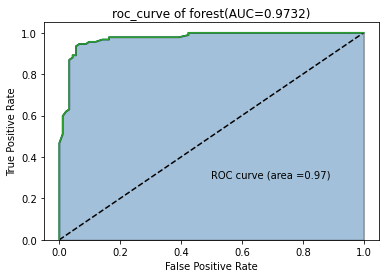

In [118]:
forest_fpr,forest_tpr,forest_threasholds=roc_curve(ya_MN_test,forest_MN_y_proba[:,1]) # 计算ROC的值,svm_threasholds为阈值
plt.title("roc_curve of %s(AUC=%.4f)" %('forest',forest_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(forest_fpr,forest_tpr)

# 绘制面积图
plt.stackplot(forest_fpr,forest_tpr,color='steelblue', alpha=0.5, edgecolor='black')
# 添加对角线
plt.plot([0,1], [0,1], color='black', linestyle='--')
# 添加边际线
plt.plot(forest_fpr, forest_tpr, color='black', lw=1)
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area =%0.2f)'%svm_auc)
plt.plot(forest_fpr, forest_tpr)
plt.savefig("./pictures/3forest__MN.jpg")

plt.show()

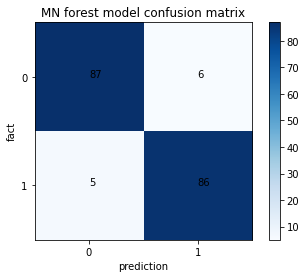

In [119]:
classes = list(set(ya_MN_test))
classes.sort()

confusion = confusion_matrix(ya_MN_test, forest_MN_y_pre)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('prediction')
plt.ylabel('fact')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.title("MN forest model confusion matrix")
plt.savefig("./pictures/3MN_forest_model_confusion_matrix.jpg")
plt.show()

In [120]:
output_predict_admet = pd.DataFrame()

In [121]:
def forestCompletePredict(x_train, x_test, y_train, y_test, x_real_test, output_predict, objectName, roc_savepath, cm_savepath):
    DisplayStartInfo()
    forest = RandomForestClassifier(n_estimators=100,random_state=2018) #　随机森林
    forest.fit(x_train,y_train)
    forest_y_pre = forest.predict(x_test)
    forest_y_proba = forest.predict_proba(x_test)
    
    output_predict[objectName] = forest.predict(x_real_test)
    # print(output_predict[objectName])
    
    forest_accuracy_score=accuracy_score(y_test,forest_y_pre)
    forest_preci_score=precision_score(y_test,forest_y_pre)
    forest_recall_score=recall_score(y_test,forest_y_pre)
    forest_f1_score=f1_score(y_test,forest_y_pre)
    forest_auc=roc_auc_score(y_test,forest_y_proba[:,1])
    print(objectName + 'forest_accuracy_score: %f,forest_preci_score: %f,forest_recall_score: %f,forest_f1_score: %f,forest_auc: %f'
        %(forest_accuracy_score,forest_preci_score,forest_recall_score,forest_f1_score,forest_auc))
    
    
    forest_fpr,forest_tpr,forest_threasholds=roc_curve(y_test,forest_y_proba[:,1]) # 计算ROC的值,svm_threasholds为阈值
    plt.title("roc_curve of %s(AUC=%.4f)" %('forest',forest_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(forest_fpr,forest_tpr)

    # 绘制面积图
    plt.stackplot(forest_fpr,forest_tpr,color='steelblue', alpha=0.5, edgecolor='black')
    # 添加对角线
    plt.plot([0,1], [0,1], color='black', linestyle='--')
    # 添加边际线
    plt.plot(forest_fpr, forest_tpr, color='black', lw=1)
    # 添加文本信息
    plt.text(0.5, 0.3, objectName + ' ROC curve (area =%0.2f)'%svm_auc)
    plt.plot(forest_fpr, forest_tpr)
    plt.savefig(roc_savepath)

    plt.show()
    
    classes = list(set(ya_MN_test))
    classes.sort()

    confusion = confusion_matrix(y_test, forest_y_pre)
    plt.imshow(confusion, cmap=plt.cm.Blues)
    indices = range(len(confusion))
    plt.xticks(indices, classes)
    plt.yticks(indices, classes)
    plt.colorbar()
    plt.xlabel('prediction')
    plt.ylabel('fact')
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index])
    plt.title(objectName + " forest model confusion matrix")
    plt.savefig(cm_savepath)
    plt.show()
    DisplayCompletedInfo()

-------------------------Start-------------------------
2021-10-20 09:58:58
Caco-2forest_accuracy_score: 0.921053,forest_preci_score: 0.917197,forest_recall_score: 0.929032,forest_f1_score: 0.923077,forest_auc: 0.978675


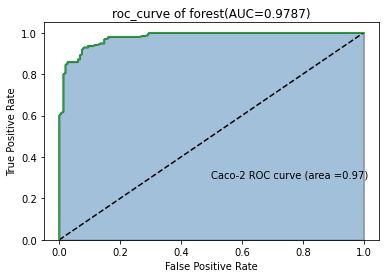

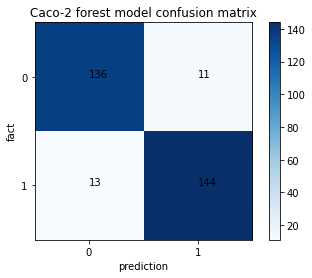

Completed at 2021-10-20 09:58:59.

-------------------------Completed-------------------------


In [122]:
forestCompletePredict(xa_caco2_train, xa_caco2_test, ya_caco2_train, ya_caco2_test, x_test, 
                      output_predict_admet, 'Caco-2', './pictures/3Caco2_ROC.jpg', 
                      './pictures/3Caco2_CM.jpg')

-------------------------Start-------------------------
2021-10-20 09:58:59
CYP3A4forest_accuracy_score: 0.922330,forest_preci_score: 0.990385,forest_recall_score: 0.872881,forest_f1_score: 0.927928,forest_auc: 0.980403


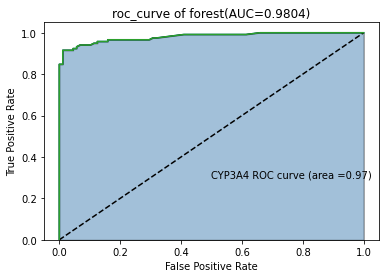

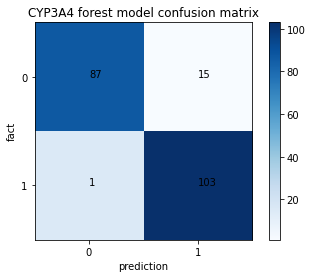

Completed at 2021-10-20 09:59:01.

-------------------------Completed-------------------------


In [123]:
forestCompletePredict(xa_CYP3A4_train, xa_CYP3A4_test, ya_CYP3A4_train, ya_CYP3A4_test, x_test, 
                      output_predict_admet, 'CYP3A4', './pictures/3CYP3A4_ROC.jpg', 
                      './pictures/3CYP3A4_CM.jpg')

-------------------------Start-------------------------
2021-10-20 09:59:01
hERGforest_accuracy_score: 0.868571,forest_preci_score: 0.826590,forest_recall_score: 0.899371,forest_f1_score: 0.861446,forest_auc: 0.956189


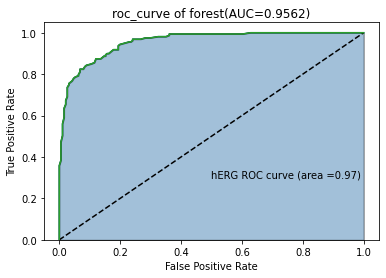

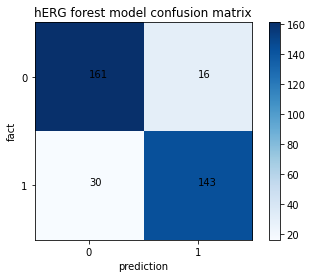

Completed at 2021-10-20 09:59:02.

-------------------------Completed-------------------------


In [124]:
forestCompletePredict(xa_hERG_train, xa_chERG_test, ya_hERG_train, ya_hERG_test, x_test, 
                      output_predict_admet, 'hERG', './pictures/3hERG_ROC.jpg', 
                      './pictures/3hERG_CM.jpg')

-------------------------Start-------------------------
2021-10-20 09:59:02
HOBforest_accuracy_score: 0.838235,forest_preci_score: 0.862745,forest_recall_score: 0.822430,forest_f1_score: 0.842105,forest_auc: 0.918778


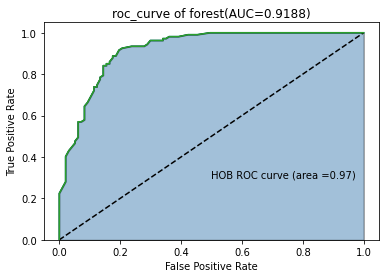

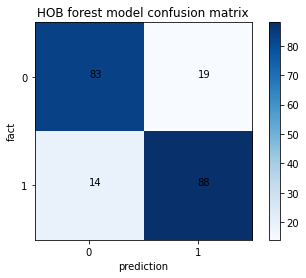

Completed at 2021-10-20 09:59:03.

-------------------------Completed-------------------------


In [125]:
forestCompletePredict(xa_HOB_train, xa_HOB_test, ya_HOB_train, ya_HOB_test , x_test, 
                      output_predict_admet, 'HOB', './pictures/3HOB_ROC.jpg', 
                      './pictures/3HOB_CM.jpg')

-------------------------Start-------------------------
2021-10-20 09:59:03
MNforest_accuracy_score: 0.940217,forest_preci_score: 0.945055,forest_recall_score: 0.934783,forest_f1_score: 0.939891,forest_auc: 0.973240


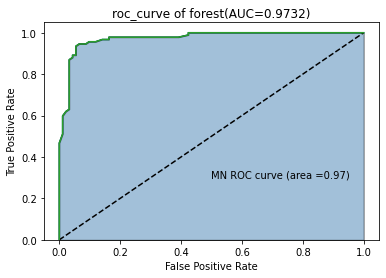

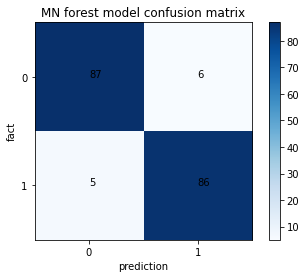

Completed at 2021-10-20 09:59:04.

-------------------------Completed-------------------------


In [126]:
forestCompletePredict(xa_MN_train, xa_MN_test, ya_MN_train, ya_MN_test, x_test, 
                      output_predict_admet, 'MN', './pictures/3MN_ROC.jpg', 
                      './pictures/3MN_CM.jpg')

In [127]:
print(output_predict_admet)
output_predict_admet.to_csv("./data/2output_predict_admet.csv")

    Caco-2  CYP3A4  hERG  HOB  MN
0        0       1     0    0   1
1        0       0     0    0   1
2        0       1     0    0   1
3        0       1     0    1   1
4        0       1     0    0   1
5        0       1     0    1   1
6        0       1     0    0   1
7        0       1     0    1   1
8        0       1     0    1   1
9        0       1     1    0   1
10       0       1     1    0   1
11       0       1     1    0   1
12       0       1     1    0   1
13       0       1     1    0   1
14       0       1     1    0   1
15       0       1     1    0   1
16       0       1     1    0   1
17       0       1     0    0   1
18       0       0     0    1   1
19       0       0     0    1   1
20       0       1     0    0   1
21       0       1     0    0   1
22       0       0     0    1   0
23       0       0     0    1   0
24       1       0     0    1   0
25       1       0     0    0   0
26       0       1     1    0   1
27       0       1     1    0   1
28       0    

# <a id='toc16_'></a>[问题4](#toc0_)
- 第四问，先找出ADMET中有三个1的实验，然后就第一问选出的指标，通过第二问方式重新求得一个关系模型，其实从这里来看，第二问用可以得出关系是的算法模型，就能和本问紧密联系起来了，得到新的关系模型后，接下来就是套用优化算法寻优了，以pIC50值为目标函数，最大化寻优，或者对IC50最小化寻优。
- 本问题需要求化合物活性最高对应的相应参数的取值或者范围，是常规的非线性模型和智能优化算法的结合优化问题。需要结合2.2预测应用模型，以最常用的BP神经网络为例，在训练和测试BP神经网络精度后，以BP神经网络的输出最大值（活性，plc50值最大）作为智能优化算法的适应度函数，第一问的前20个最重要作为优化参数，即可求解。相关的智能优化算法，可以用遗传算法，粒子群算法，参考文献较多，实现起来容易。

# <a id='toc17_'></a>[注意](#toc0_)
1. 从5个选修>=3个（有毒的取反，hERG和MN是有毒的）的.
2. 以活性最大为约束条件，使用优化算法。


In [128]:
admet_origin.columns

Index(['SMILES', 'Caco-2', 'CYP3A4', 'hERG', 'HOB', 'MN'], dtype='object')

In [129]:
admet_origin_columns_select = ['Caco-2', 'CYP3A4', 'hERG', 'HOB', 'MN']
# y_data_pic50就是ERa_activity中的pic50值。
samples_alltemp1 = pd.concat([x_data, admet_origin[admet_origin_columns_select]], axis=1)
samples_all = pd.concat([samples_alltemp1, y_data_pic50], axis=1)

print(samples_all.head())

   nAcid     ALogP    ALogP2       AMR      apol  naAromAtom  nAromBond  \
0    0.0  0.806704  0.000153  0.155498  0.132244         0.4   0.352941   
1    0.0  0.786341  0.001392  0.168065  0.151050         0.4   0.352941   
2    0.0  0.842608  0.000997  0.185305  0.131924         0.6   0.529412   
3    0.0  0.805559  0.000190  0.171389  0.151050         0.4   0.352941   
4    0.0  0.864721  0.003440  0.192340  0.138889         0.6   0.529412   

      nAtom  nHeavyAtom        nH  ...     WPATH      WPOL     XLogP  \
0  0.133540    0.114094  0.160000  ...  0.008834  0.152778  0.461986   
1  0.152174    0.127517  0.182857  ...  0.010510  0.185185  0.525650   
2  0.127329    0.127517  0.137143  ...  0.010596  0.175926  0.366769   
3  0.152174    0.127517  0.182857  ...  0.010769  0.166667  0.537455   
4  0.133540    0.127517  0.148571  ...  0.010769  0.166667  0.450573   

     Zagreb  Caco-2  CYP3A4  hERG  HOB  MN  pIC50  
0  0.151603       0       1     1    0   0  8.602  
1  0.163265 

In [130]:
print(samples_all.head(20))

    nAcid     ALogP    ALogP2       AMR      apol  naAromAtom  nAromBond  \
0     0.0  0.806704  0.000153  0.155498  0.132244    0.400000   0.352941   
1     0.0  0.786341  0.001392  0.168065  0.151050    0.400000   0.352941   
2     0.0  0.842608  0.000997  0.185305  0.131924    0.600000   0.529412   
3     0.0  0.805559  0.000190  0.171389  0.151050    0.400000   0.352941   
4     0.0  0.864721  0.003440  0.192340  0.138889    0.600000   0.529412   
5     0.0  0.802953  0.000288  0.174137  0.125453    0.600000   0.529412   
6     0.0  0.870391  0.004302  0.190478  0.140774    0.600000   0.529412   
7     0.0  0.813230  0.000019  0.162611  0.117171    0.566667   0.500000   
8     0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
9     0.0  0.869165  0.004108  0.125867  0.067967    0.600000   0.529412   
10    0.0  0.819484  0.000011  0.193694  0.137542    0.600000   0.529412   
11    0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
12    0.0  0

In [131]:
# hERG和MN是有毒的，需要取反。
def anti(input):
    if input == 0:
        return 1
    else:
        return 0
samples_all['hERG'] = samples_all['hERG'].apply(lambda x: anti(x))
samples_all['MN'] = samples_all['MN'].apply(lambda x: anti(x))

print(samples_all.shape)
print(samples_all.head(20))

(1974, 735)
    nAcid     ALogP    ALogP2       AMR      apol  naAromAtom  nAromBond  \
0     0.0  0.806704  0.000153  0.155498  0.132244    0.400000   0.352941   
1     0.0  0.786341  0.001392  0.168065  0.151050    0.400000   0.352941   
2     0.0  0.842608  0.000997  0.185305  0.131924    0.600000   0.529412   
3     0.0  0.805559  0.000190  0.171389  0.151050    0.400000   0.352941   
4     0.0  0.864721  0.003440  0.192340  0.138889    0.600000   0.529412   
5     0.0  0.802953  0.000288  0.174137  0.125453    0.600000   0.529412   
6     0.0  0.870391  0.004302  0.190478  0.140774    0.600000   0.529412   
7     0.0  0.813230  0.000019  0.162611  0.117171    0.566667   0.500000   
8     0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
9     0.0  0.869165  0.004108  0.125867  0.067967    0.600000   0.529412   
10    0.0  0.819484  0.000011  0.193694  0.137542    0.600000   0.529412   
11    0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   


In [132]:
# import pyswarms as ps
def calcAdmetBE3(dataDF):
    # print(dataDF.shape)
    if dataDF['Caco-2'] + dataDF['CYP3A4'] + dataDF['hERG']+ dataDF['HOB']+ dataDF['MN'] >= 3:
        return 1
    else:
        return 0

samples_all['admetBE3'] = samples_all.apply(lambda x: calcAdmetBE3(x), axis=1)
print(samples_all.head(20))

    nAcid     ALogP    ALogP2       AMR      apol  naAromAtom  nAromBond  \
0     0.0  0.806704  0.000153  0.155498  0.132244    0.400000   0.352941   
1     0.0  0.786341  0.001392  0.168065  0.151050    0.400000   0.352941   
2     0.0  0.842608  0.000997  0.185305  0.131924    0.600000   0.529412   
3     0.0  0.805559  0.000190  0.171389  0.151050    0.400000   0.352941   
4     0.0  0.864721  0.003440  0.192340  0.138889    0.600000   0.529412   
5     0.0  0.802953  0.000288  0.174137  0.125453    0.600000   0.529412   
6     0.0  0.870391  0.004302  0.190478  0.140774    0.600000   0.529412   
7     0.0  0.813230  0.000019  0.162611  0.117171    0.566667   0.500000   
8     0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
9     0.0  0.869165  0.004108  0.125867  0.067967    0.600000   0.529412   
10    0.0  0.819484  0.000011  0.193694  0.137542    0.600000   0.529412   
11    0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
12    0.0  0

In [133]:
print(samples_all.head(20))

    nAcid     ALogP    ALogP2       AMR      apol  naAromAtom  nAromBond  \
0     0.0  0.806704  0.000153  0.155498  0.132244    0.400000   0.352941   
1     0.0  0.786341  0.001392  0.168065  0.151050    0.400000   0.352941   
2     0.0  0.842608  0.000997  0.185305  0.131924    0.600000   0.529412   
3     0.0  0.805559  0.000190  0.171389  0.151050    0.400000   0.352941   
4     0.0  0.864721  0.003440  0.192340  0.138889    0.600000   0.529412   
5     0.0  0.802953  0.000288  0.174137  0.125453    0.600000   0.529412   
6     0.0  0.870391  0.004302  0.190478  0.140774    0.600000   0.529412   
7     0.0  0.813230  0.000019  0.162611  0.117171    0.566667   0.500000   
8     0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
9     0.0  0.869165  0.004108  0.125867  0.067967    0.600000   0.529412   
10    0.0  0.819484  0.000011  0.193694  0.137542    0.600000   0.529412   
11    0.0  0.920072  0.015981  0.122651  0.071198    0.600000   0.529412   
12    0.0  0

In [134]:
samples_all["admetBE3"].value_counts()

0    1342
1     632
Name: admetBE3, dtype: int64

In [135]:
# 把大于等于3的列都找出来。
# 注意：现在使用的数据已经做了归一化处理。所以所有值的最大值和最小值范围都已经确定了。
# 现在先需要确定如何使用优化算法。
samples_be3_1 = samples_all.loc[samples_all["admetBE3"] == 1].copy()
samples_be3 = samples_be3_1.drop(['Caco-2', 'CYP3A4', 'hERG', 'HOB', 'MN'], axis=1).copy()
# print(samples_be3.head())
print(samples_be3.shape)
print(samples_be3.describe())

(632, 731)
            nAcid       ALogP        ALogP2         AMR        apol  \
count  632.000000  632.000000  6.320000e+02  632.000000  632.000000   
mean     0.012658    0.856021  5.505622e-03    0.096084    0.063234   
std      0.060028    0.046255  8.196913e-03    0.047959    0.039742   
min      0.000000    0.559075  1.198859e-09    0.000000    0.000000   
25%      0.000000    0.824427  5.665997e-04    0.065952    0.033978   
50%      0.000000    0.855305  2.694522e-03    0.079877    0.055237   
75%      0.000000    0.887158  7.659374e-03    0.115286    0.080767   
max      0.500000    1.000000  9.956681e-02    0.406034    0.416070   

       naAromAtom   nAromBond       nAtom  nHeavyAtom          nH  ...  \
count  632.000000  632.000000  632.000000  632.000000  632.000000  ...   
mean     0.412500    0.384401    0.068608    0.066042    0.081438  ...   
std      0.187194    0.182245    0.038769    0.036547    0.047404  ...   
min      0.000000    0.000000    0.012422    0.000000

In [136]:
x_be3_data = samples_be3.drop(['pIC50','admetBE3'], axis=1).copy()
y_be3_data = samples_be3['pIC50'].copy()
xs_be3_train, xs_be3_test, ys_be3_train, ys_be3_test = train_test_split(x_be3_data, y_be3_data, test_size=0.2, 
                                                        random_state=2020, shuffle=False)


In [137]:
print(x_be3_data.shape)
print(y_be3_data.shape)

(632, 729)
(632,)


In [138]:
print(samples_be3.shape)
samples_be3.head()

(632, 731)


,nAcid,ALogP,ALogP2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,pIC50,admetBE3
8,0.0,0.920072,0.015981,0.122651,0.071198,0.6,0.529412,0.068323,0.073826,0.074286,...,0.835301,0.014472,0.100046,0.000000,0.003236,0.143519,0.445874,0.122449,8.367,1
9,0.0,0.869165,0.004108,0.125867,0.067967,0.6,0.529412,0.062112,0.087248,0.051429,...,0.744663,0.043579,0.203280,0.000000,0.003972,0.189815,0.297343,0.139942,7.041,1
11,0.0,0.920072,0.015981,0.122651,0.071198,0.6,0.529412,0.068323,0.073826,0.074286,...,0.835178,0.014511,0.100181,0.000000,0.003176,0.143519,0.445874,0.122449,7.456,1
12,0.0,0.874832,0.005045,0.158945,0.126894,0.4,0.352941,0.130435,0.107383,0.160000,...,0.583257,0.071730,0.173948,0.027092,0.008021,0.152778,0.439441,0.142857,7.959,1
15,0.0,0.849106,0.001563,0.158066,0.126894,0.4,0.352941,0.130435,0.107383,0.160000,...,0.620988,0.071884,0.174120,0.027093,0.008193,0.143519,0.460979,0.137026,8.523,1


In [139]:
be3_min = Molecular_Descriptor_filled[new_columns_20].min()
be3_max = Molecular_Descriptor_filled[new_columns_20].max()

# print(be3_min)
# print(be3_max)
# print(be3_min.shape)
# print(be3_max.shape)

be3_min_list = list(be3_min.T)
be3_max_list = list(be3_max.T)
print(len(be3_min_list))
print(be3_max_list)

20
[30.02512935, 1.520189295, 0.604460284, 7.00306502, -0.015630594, 5.1817, 2.141957979, 0.527629816, 10.59432217, 10.08211514, 14.283, 6.0, 65.62532567, 0.537745503, 1.118276998, 2.025780849, -0.188736311, 13.6650479, 35.32070534, 13.0992776]


In [140]:
# 线性回归进行预测。
DisplayStartInfo()

lrg_20 = LinearRegression() 
lrg_20.fit(xs_be3_train[new_columns_20],ys_be3_train)
lrg_20_y_pre = lrg_20.predict(xs_be3_test[new_columns_20])
print(lrg_20_y_pre)
lrg_20_y_pre_pd = pd.DataFrame(lrg_20_y_pre)
# lrg_20_y_proba = lrg_20.predict(xs_test[importances_20_name])

DisplayCompletedInfo()

-------------------------Start-------------------------
2021-10-20 09:59:06
[6.22561655 5.67000374 6.42135849 6.24354396 5.67551507 6.23752112
 5.71840786 6.16519173 7.23883891 6.15911523 7.49245819 7.00898677
 6.85484289 7.24839486 7.38048223 6.96766927 7.2013538  6.67461902
 7.0369415  7.14797131 7.43486983 6.72309478 6.85186151 6.98360524
 6.69582375 5.73930102 6.38804706 6.24146546 6.19747205 7.29563311
 6.47042007 6.8863566  7.35599518 6.09750073 7.97844211 7.21563919
 7.37669284 5.18879015 5.23456904 4.4253352  6.01131018 6.85096228
 6.86302937 6.92536784 6.36369576 6.46510202 5.95636803 5.94847209
 2.76179037 6.5413731  5.8430113  7.10313671 7.24565035 7.41775361
 7.37490655 7.97232834 7.53068463 7.45648087 7.44513279 7.35768407
 7.53068463 7.48719205 7.48719205 7.54770854 6.34007715 6.28159256
 6.22004582 6.09071323 6.47694441 6.80598521 6.39622738 5.05875149
 5.58383305 5.25771623 7.63752249 5.71863578 5.71863578 7.26041947
 4.79785354 5.81485509 7.29653163 7.38257026 6.575392

In [141]:
print(lrg_20.coef_)
print(lrg_20.intercept_)

[ 0.70681453  0.96189732 -5.96025625 -1.15279693  8.53368223  6.43943367
  0.59753536  0.10601312  0.91525938  0.73983735  1.0105341  -0.20205201
  1.01408075  1.26024542 -0.27117664 -1.6573508  -1.13795833 -0.85019527
  1.65294052  1.10812544]
-3.6767050001044295


In [142]:
# 使用遗传算法。约束条件就是在samples_be3（已经对admet进行了）集合中使得pIC50最大。
from sko.GA import GA, GA_TSP
from sko.operators import ranking, selection, crossover, mutation
# lrg.coef_这个是系数矩阵  这是关系模型。
# lrg.intercept_这个是截距。也就是常数项。

def selection_tournament(algorithm, tourn_size):
    FitV = algorithm.FitV
    sel_index = []
    for i in range(algorithm.size_pop):
        aspirants_index = np.random.choice(range(algorithm.size_pop), size=tourn_size)
        sel_index.append(max(aspirants_index, key=lambda i: FitV[i]))
    algorithm.Chrom = algorithm.Chrom[sel_index, :]  # next generation
    return algorithm.Chrom
# 729
inputDataShape = 20

def demo_func(X):
    # print(pd.DataFrame(X).T.shape)
    # print(pd.DataFrame(X).T)
    # print(type(X))
    output = lrg_20.predict(pd.DataFrame(X).T)
    # print(output.shape)
    # print(type(output))
    # print(output)
    return -output

ga = GA(func=demo_func, n_dim=inputDataShape, size_pop=20, lb= be3_min_list, ub=be3_max_list,
        max_iter=700, precision=1e-7)
ga.register(operator_name='selection', operator=selection_tournament, tourn_size=inputDataShape)
ga.register(operator_name='ranking', operator=ranking.ranking). \
    register(operator_name='crossover', operator=crossover.crossover_2point). \
    register(operator_name='mutation', operator=mutation.mutation)
    
best_x, best_y = ga.run()
# print('best_x:', best_x, '\n', 'best_y:', - best_y)

In [143]:
print('best_x:', best_x, '\n', 'best_y:', - best_y)

best_x: [ 3.00249386e+01  1.51870329e+00 -2.88996844e+00  2.93879588e+00
 -1.58335687e-02  5.18040466e+00  2.14195009e+00  5.27611843e-01
  1.05898733e+01  1.00820288e+01  1.42735692e+01  9.27150263e-05
  6.56252005e+01  5.37738827e-01  4.05259404e-05 -1.90291455e+00
 -4.21482404e-01 -2.42263251e+00  3.53207046e+01  1.30992689e+01] 
 best_y: [[244.79706103]]


In [144]:
type(ga.generation_best_Y)
for i in range(len(ga.generation_best_Y)):
    ga.generation_best_Y[i] = - ga.generation_best_Y[i]

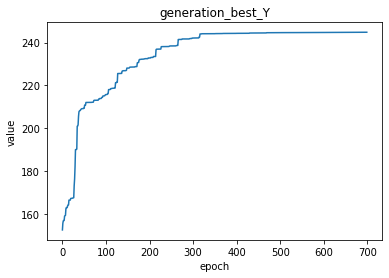

In [145]:

plt.plot(ga.generation_best_Y)
plt.title("generation_best_Y")
plt.xlabel("epoch")
plt.ylabel("value")
plt.savefig("./pictures/4ga_generation_best_Y.jpg")
plt.show()

In [146]:
ga_generation_best_X_pd = pd.DataFrame(ga.generation_best_X)
print(ga_generation_best_X_pd.shape)

(700, 20)


In [147]:
ga_generation_best_X_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,16.864511,1.335945,-1.170674,5.678023,-1.489241,3.520048,2.000527,0.104743,6.448236,2.829786,13.827970,4.734944,63.615582,0.157858,0.834750,1.422171,-0.254382,12.151938,26.949894,12.539754
1,16.864511,1.335945,-1.170691,4.397271,-0.208616,2.666777,2.126087,0.406404,5.339096,-0.437639,14.203024,5.935451,63.799602,-0.053999,0.476222,1.799662,-0.254382,12.151938,26.949894,12.539754
2,16.864511,1.335945,-1.170691,4.397271,-0.208616,2.666777,2.126087,0.406404,6.788034,-0.437639,14.203024,5.934978,63.615579,-0.053999,0.476222,1.799662,-0.254382,12.151938,26.949894,12.539754
3,16.864511,1.335945,-1.170691,4.397271,-0.208616,2.666777,2.126087,0.406402,6.788034,-0.437639,14.203024,5.934978,63.615579,-0.053999,0.476222,1.799662,-0.356116,12.151938,26.949894,12.539754
4,16.864511,1.335945,-1.170691,4.397271,-0.208616,2.666777,2.126087,0.406404,6.788034,-0.437639,14.203024,5.934978,63.615579,-0.053999,0.476222,1.799662,-0.356116,12.151938,26.949894,12.539754


In [148]:
new_columns_20

['SssO',
 'maxssCH2',
 'ATSc5',
 'BCUTp-1l',
 'ATSc2',
 'ALogP',
 'WTPT-2',
 'BCUTc-1h',
 'minHBint10',
 'minHBint4',
 'XLogP',
 'n6Ring',
 'SsOH',
 'ATSc3',
 'maxHCsatu',
 'mindssC',
 'BCUTc-1l',
 'minHBa',
 'MDEC-22',
 'SdssC']

In [149]:
bestx_output = pd.DataFrame(columns=new_columns_20)
bestx_output.loc[0] = best_x
print(bestx_output)
bestx_output.to_csv("./data/4GA_bestx.csv")
print()
# i know very nervous, but my teammate forget modify the bestx result table in competition last time.
# what a pity!

        SssO  maxssCH2     ATSc5  BCUTp-1l     ATSc2     ALogP   WTPT-2  \
0  30.024939  1.518703 -2.889968  2.938796 -0.015834  5.180405  2.14195   

   BCUTc-1h  minHBint10  minHBint4      XLogP    n6Ring     SsOH     ATSc3  \
0  0.527612   10.589873  10.082029  14.273569  0.000093  65.6252  0.537739   

   maxHCsatu   mindssC  BCUTc-1l    minHBa    MDEC-22      SdssC  
0   0.000041 -1.902915 -0.421482 -2.422633  35.320705  13.099269  



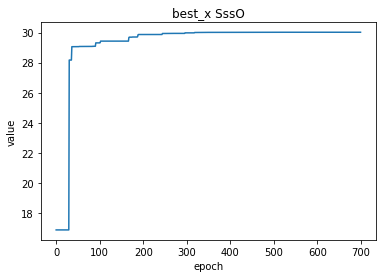

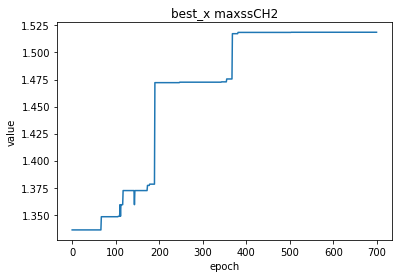

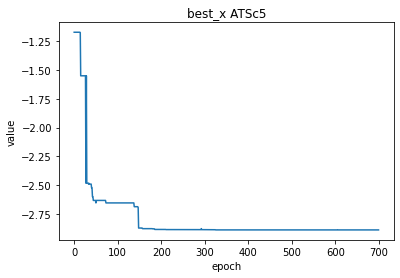

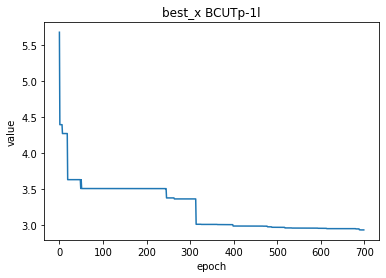

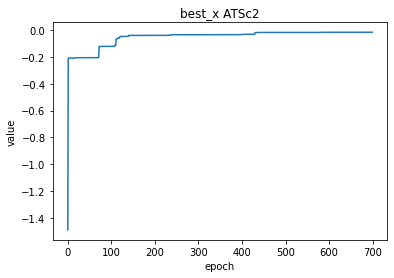

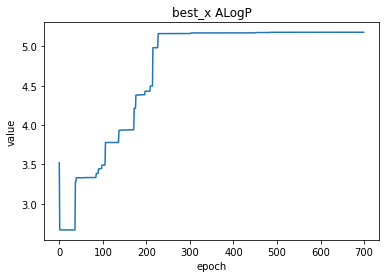

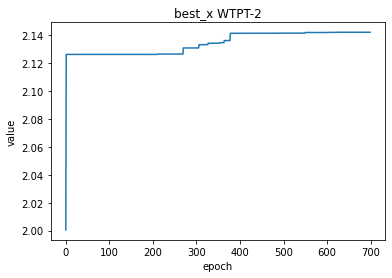

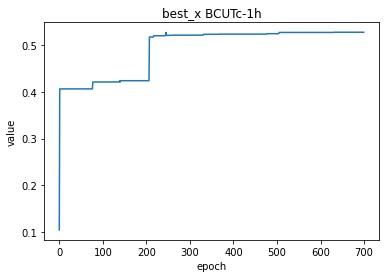

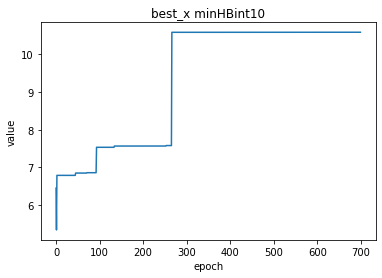

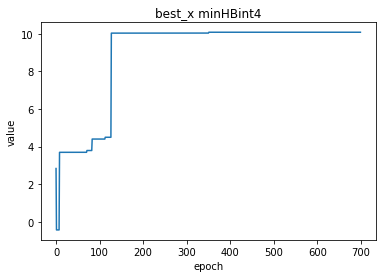

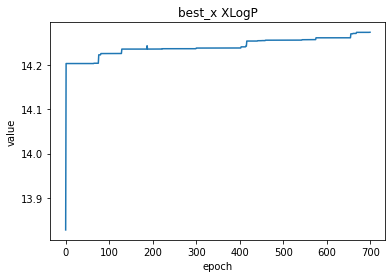

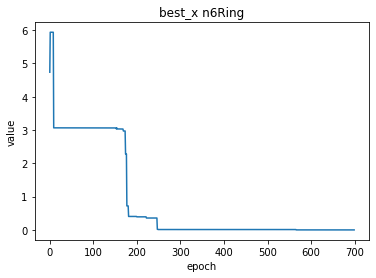

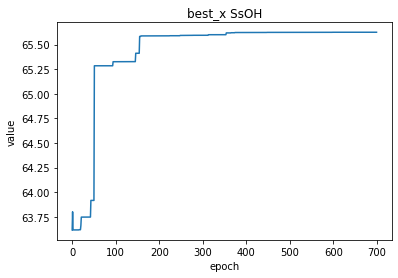

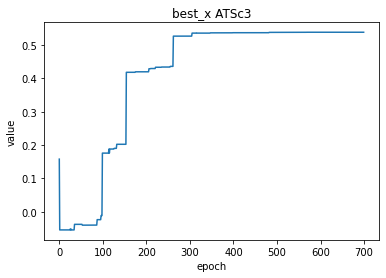

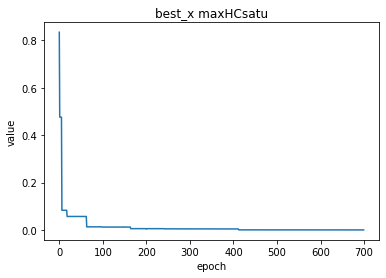

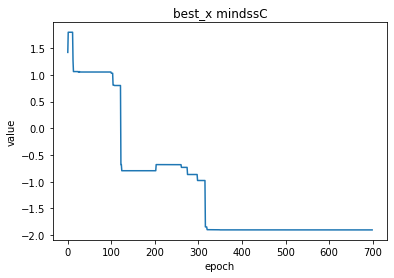

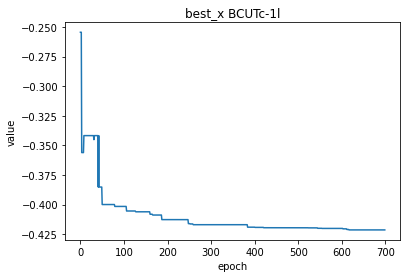

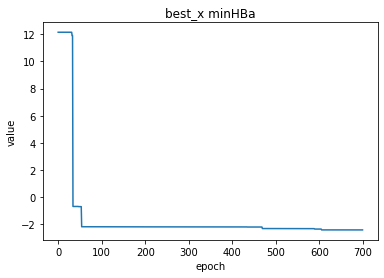

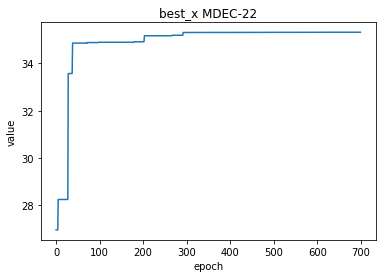

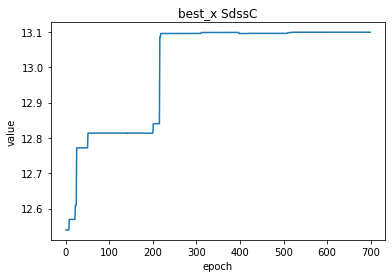

In [150]:
for i in range(20):
    plt.plot(ga_generation_best_X_pd[i])
    plt.title("best_x " + new_columns_20[i])
    plt.xlabel("epoch")
    plt.ylabel("value")
    plt.savefig("./pictures/4ga_best_x_" + new_columns_20[i] +".jpg")
    plt.show()

best_x is  [-100000. -100000.  100000.  100000. -100000. -100000. -100000. -100000.
 -100000. -100000. -100000.  100000. -100000. -100000.  100000.  100000.
  100000.  100000. -100000. -100000.] best_y is [-3627822.22075416]


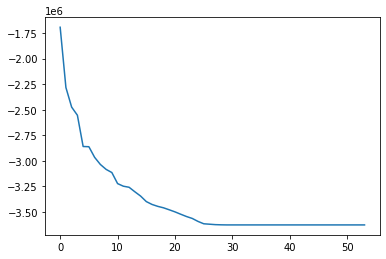

In [151]:
from sko.PSO import PSO
num_points = 20
def demo_func(X):
    output = lrg_20.predict(pd.DataFrame(X).T)
    return output

pso = PSO(func=demo_func, n_dim=num_points, pop=40, max_iter=150, w=0.8, c1=0.5, c2=0.5)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

plt.plot(pso.gbest_y_hist)
plt.show()